In [5]:
pip install torch pandas numpy scikit-learn matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Убраны импорты Scheduler и EarlyStopping
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# Убран класс EarlyStopping

# --- Класс для Residual Block (остается как был) ---
class ResidualBlock(nn.Module):
    """Остаточный блок: Linear -> BN -> ReLU -> Linear -> BN + Shortcut"""
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)
        if input_dim != output_dim:
            self.shortcut = nn.Sequential(nn.Linear(input_dim, output_dim, bias=False), nn.BatchNorm1d(output_dim))
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.linear1(x)
        if out.shape[0] > 1: out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        if out.shape[0] > 1: out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# --- Класс для Wide & Deep Модели с ResBlocks в Deep части ---
class WideAndDeepWithResBlocks(nn.Module):
    def __init__(self, input_dim, h_initial, h_b1, h_b2, h_b3, h_b4, wide_output_dim, final_hidden_dim, output_dim):
        super(WideAndDeepWithResBlocks, self).__init__()

        # --- Deep Path ---
        self.initial_deep = nn.Sequential(nn.Linear(input_dim, h_initial), nn.BatchNorm1d(h_initial), nn.ReLU())
        self.resblock1 = ResidualBlock(h_initial, h_b1) # h_initial -> h_b1
        self.resblock2 = ResidualBlock(h_b1, h_b2)       # h_b1 -> h_b2
        self.resblock3 = ResidualBlock(h_b2, h_b3)       # h_b2 -> h_b3
        self.resblock4 = ResidualBlock(h_b3, h_b4)       # h_b3 -> h_b4
        self.deep_output_dim = h_b4 # Размерность выхода глубокой части

        # --- Wide Path ---
        self.wide_layer = nn.Linear(input_dim, wide_output_dim)
        self.wide_output_dim = wide_output_dim

        # --- Combined Path ---
        # Размерность после конкатенации
        combined_input_dim = self.deep_output_dim + self.wide_output_dim
        # Добавляем еще один скрытый слой перед выходом для лучшего смешивания
        self.final_hidden_layer = nn.Sequential(
            nn.Linear(combined_input_dim, final_hidden_dim),
            nn.ReLU()
            # Можно добавить BN и сюда nn.BatchNorm1d(final_hidden_dim),
        )
        self.output_layer = nn.Linear(final_hidden_dim, output_dim)

    def forward(self, x):
        # Deep path
        deep_out = self.initial_deep(x)
        deep_out = self.resblock1(deep_out)
        deep_out = self.resblock2(deep_out)
        deep_out = self.resblock3(deep_out)
        deep_out = self.resblock4(deep_out)

        # Wide path
        wide_out = self.wide_layer(x)

        # Combine
        combined = torch.cat((deep_out, wide_out), dim=1)

        # Final layers
        final_hidden = self.final_hidden_layer(combined)
        final_output = self.output_layer(final_hidden)
        return final_output

# --- Configuration ---


DATA_FILE_PATH = '0moex_qcml_final_dataset_with_embeddings.parquet'
TARGET_COLUMN = 'FinalTarget'; DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Wide & Deep с ResBlocks)
INPUT_DIM = -1
# Размеры для Deep части (ResBlocks)
H_INITIAL = 128
H_BLOCK1_OUT = 128
H_BLOCK2_OUT = 64
H_BLOCK3_OUT = 32
H_BLOCK4_OUT = 16 # Выход Deep части будет 16
# Размерность Wide части
WIDE_OUTPUT_DIM = 16
# Размерность слоя после объединения
FINAL_HIDDEN_DIM = 32 # Например, 16+16 -> 32
OUTPUT_DIM = 1
# Параметры обучения
LEARNING_RATE = 0.001
BATCH_SIZE = 512
EPOCHS = 180

# Путь для сохранения лучшей ТРЕНИРОВОЧНОЙ модели
BEST_TRAIN_MODEL_PATH = 'best_train_loss_wide_deep_resnet_model.pt' # Новое имя

# --- Phase 1, 2, 3 (Без изменений) ---
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
# ... (код загрузки, проверки, сортировки, разбиения, масштабирования) ...
if not os.path.exists(DATA_FILE_PATH): print(f"ОШИБКА: Файл не найден {DATA_FILE_PATH}"); raise FileNotFoundError
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet: {e}"); raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN];
if not all(col in df.columns for col in required_cols): print(f"ОШИБКА: Отсутствуют столбцы: {[c for c in required_cols if c not in df.columns]}"); raise ValueError
else: print(f"Столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]];
if not feature_columns: print("ОШИБКА: Нет признаков."); raise ValueError
INPUT_DIM = len(feature_columns); print(f"Найдено {INPUT_DIM} столбцов-признаков.")
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: print(f"ОШИБКА конвертации '{DATE_COLUMN}': {e}"); raise
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True); print(f"Данные отсортированы.")
split_idx = int(len(df) * 0.9); last_train_date = df.loc[split_idx - 1, DATE_COLUMN]
actual_split_idx = (df[DATE_COLUMN] > last_train_date).idxmax()
if actual_split_idx == 0 and split_idx > 0 : actual_split_idx = split_idx
train_df = df.iloc[:actual_split_idx].copy(); test_df = df.iloc[actual_split_idx:].copy()
if train_df.empty or test_df.empty: print(f"ОШИБКА: Пустой датасет после разбиения! Индекс: {actual_split_idx}"); raise ValueError
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные: {len(train_df)} ({train_start} - {train_end})"); print(f"Тестовые: {len(test_df)} ({test_start} - {test_end})")
if train_end < test_start: print("Хронологическое разбиение успешно.")
elif train_end == test_start: print("ВНИМАНИЕ: Граница разбиения по одной дате.")
else: print(f"ОШИБКА: Перекрытие дат! {train_end} vs {test_start}")
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print(f"Цель (трейн) после масштабирования: mean={np.mean(y_train_scaled):.4f}, std={np.std(y_train_scaled):.4f}")
print(f"Цель (тест) после масштабирования: mean={np.mean(y_test_scaled):.4f}, std={np.std(y_test_scaled):.4f}")

# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor); test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем Wide & Deep модель
model = WideAndDeepWithResBlocks(
    input_dim=INPUT_DIM,
    h_initial=H_INITIAL,
    h_b1=H_BLOCK1_OUT,
    h_b2=H_BLOCK2_OUT,
    h_b3=H_BLOCK3_OUT,
    h_b4=H_BLOCK4_OUT,
    wide_output_dim=WIDE_OUTPUT_DIM,
    final_hidden_dim=FINAL_HIDDEN_DIM,
    output_dim=OUTPUT_DIM
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # LR = 0.001

# Планировщик УБРАН
# Early Stopping УБРАН

# Training Loop
train_losses = []; val_losses = []
best_train_loss = np.inf
start_time = time.time()
print(f"Начало обучения Wide & Deep модели с ResBlocks, LR={LEARNING_RATE}, BatchSize={BATCH_SIZE}...")

for epoch in range(EPOCHS): # EPOCHS = 200
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Сохранение модели по лучшему Train Loss
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), BEST_TRAIN_MODEL_PATH)
        print(f"*** Новый лучший Train Loss: {best_train_loss:.6f}. Модель сохранена в {BEST_TRAIN_MODEL_PATH} ***")

    # Фаза валидации
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Early Stopping УБРАН

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# Загрузка ЛУЧШЕЙ ТРЕНИРОВОЧНОЙ модели
print(f"Загрузка модели с лучшим Train Loss из {BEST_TRAIN_MODEL_PATH}")
try:
    # Создаем экземпляр правильной модели
    final_model = WideAndDeepWithResBlocks(
        input_dim=INPUT_DIM, h_initial=H_INITIAL, h_b1=H_BLOCK1_OUT, h_b2=H_BLOCK2_OUT,
        h_b3=H_BLOCK3_OUT, h_b4=H_BLOCK4_OUT, wide_output_dim=WIDE_OUTPUT_DIM,
        final_hidden_dim=FINAL_HIDDEN_DIM, output_dim=OUTPUT_DIM
    ).to(device)
    final_model.load_state_dict(torch.load(BEST_TRAIN_MODEL_PATH))
    print("Модель с лучшим Train Loss успешно загружена.")
except FileNotFoundError:
    print(f"Ошибка: Файл {BEST_TRAIN_MODEL_PATH} не найден. Используется последняя модель из цикла.")
    final_model = model
except Exception as e:
     print(f"Ошибка при загрузке модели ({e}). Используется последняя модель из цикла.")
     final_model = model

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (с моделью с лучшим Train Loss) ---")
final_model.eval(); predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device); outputs = final_model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled); y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale); final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale); final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}"); print(f"Тестовый набор MAE: {final_mae:.6f}"); print(f"Тестовый набор R^2: {final_r2:.4f}")


# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")
epochs_ran = len(train_losses); plt.figure(figsize=(10, 5)); plt.plot(range(1, epochs_ran + 1), train_losses, label='Training Loss'); plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss')
best_train_epoch = np.argmin(train_losses) + 1; plt.axvline(best_train_epoch, linestyle='--', color='g', label=f'Лучший Train Loss (Эпоха {best_train_epoch})')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштаб.)'); plt.title('Потери (Wide & Deep с ResBlocks Модель, LR 0.001, Batch 512)')
plt.legend(); plt.grid(True); plt.ylim(bottom=min(train_losses)*0.9 if train_losses else 0, top=max(1.1, max(val_losses) * 1.1) if val_losses else 1.1); plt.show()
plt.figure(figsize=(8, 8)); plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10); plt.xlabel('Истинные значения'); plt.ylabel('Предсказанные значения'); plt.title('Истинные vs Предсказанные (Wide & Deep Модель с Лучшим Train Loss)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max()); plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x'); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()
print("\nСкрипт завершен.")


Попытка загрузить данные из: 0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков.

--- Сортировка и разбиение данных ---
Данные отсортированы.
Тренировочные: 150851 (2021-04-20 00:00:00 - 2024-11-18 00:00:00)
Тестовые: 16735 (2024-11-25 00:00:00 - 2025-03-27 00:00:00)
Хронологическое разбиение успешно.

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков...
Применение масштабировщиков...
Цель (трейн) после масштабирования: mean=0.0000, std=1.0000
Цель (тест) после масштабирования: mean=-0.0069, std=1.0036

--- Определение и Обучение Модели ---
Используемое устройство: cpu
Начало обучения Wide & Deep модели с ResBlocks, LR=0.001, BatchSize=512...
*** Новый лучший Train Loss: 1.000025. Модель сохранена в best_train_loss_wide_deep_resnet_model.pt ***
Эпоха [1/180], Train Loss: 1.000025, Val Loss: 1.014102, LR: 0.0010000
*** Новый лучший Train Loss: 0.992

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Убраны импорты Scheduler и EarlyStopping
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# Убран класс EarlyStopping

# --- Класс для Residual Block (остается как был) ---
class ResidualBlock(nn.Module):
    """Остаточный блок: Linear -> BN -> ReLU -> Linear -> BN + Shortcut"""
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)
        if input_dim != output_dim:
            self.shortcut = nn.Sequential(nn.Linear(input_dim, output_dim, bias=False), nn.BatchNorm1d(output_dim))
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.linear1(x)
        if out.shape[0] > 1: out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        if out.shape[0] > 1: out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# --- Класс для Wide & Deep Модели с ResBlocks в Deep части ---
class WideAndDeepWithResBlocks(nn.Module):
    def __init__(self, input_dim, h_initial, h_b1, h_b2, h_b3, h_b4, wide_output_dim, final_hidden_dim, output_dim):
        super(WideAndDeepWithResBlocks, self).__init__()

        # --- Deep Path ---
        self.initial_deep = nn.Sequential(nn.Linear(input_dim, h_initial), nn.BatchNorm1d(h_initial), nn.ReLU())
        self.resblock1 = ResidualBlock(h_initial, h_b1) # h_initial -> h_b1
        self.resblock2 = ResidualBlock(h_b1, h_b2)       # h_b1 -> h_b2
        self.resblock3 = ResidualBlock(h_b2, h_b3)       # h_b2 -> h_b3
        self.resblock4 = ResidualBlock(h_b3, h_b4)       # h_b3 -> h_b4
        self.deep_output_dim = h_b4 # Размерность выхода глубокой части

        # --- Wide Path ---
        self.wide_layer = nn.Linear(input_dim, wide_output_dim)
        self.wide_output_dim = wide_output_dim

        # --- Combined Path ---
        # Размерность после конкатенации
        combined_input_dim = self.deep_output_dim + self.wide_output_dim
        # Добавляем еще один скрытый слой перед выходом для лучшего смешивания
        self.final_hidden_layer = nn.Sequential(
            nn.Linear(combined_input_dim, final_hidden_dim),
            nn.ReLU()
            # Можно добавить BN и сюда nn.BatchNorm1d(final_hidden_dim),
        )
        self.output_layer = nn.Linear(final_hidden_dim, output_dim)

    def forward(self, x):
        # Deep path
        deep_out = self.initial_deep(x)
        deep_out = self.resblock1(deep_out)
        deep_out = self.resblock2(deep_out)
        deep_out = self.resblock3(deep_out)
        deep_out = self.resblock4(deep_out)

        # Wide path
        wide_out = self.wide_layer(x)

        # Combine
        combined = torch.cat((deep_out, wide_out), dim=1)

        # Final layers
        final_hidden = self.final_hidden_layer(combined)
        final_output = self.output_layer(final_hidden)
        return final_output

# --- Configuration ---


DATA_FILE_PATH = '0moex_qcml_final_dataset_with_embeddings.parquet'
TARGET_COLUMN = 'FinalTarget'; DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Wide & Deep с ResBlocks)
INPUT_DIM = -1
# Размеры для Deep части (ResBlocks)
H_INITIAL = 128
H_BLOCK1_OUT = 128
H_BLOCK2_OUT = 64
H_BLOCK3_OUT = 32
H_BLOCK4_OUT = 16 # Выход Deep части будет 16
# Размерность Wide части
WIDE_OUTPUT_DIM = 16
# Размерность слоя после объединения
FINAL_HIDDEN_DIM = 32 # Например, 16+16 -> 32
OUTPUT_DIM = 1
# Параметры обучения
LEARNING_RATE = 0.01
BATCH_SIZE = 512
EPOCHS = 120

# Путь для сохранения лучшей ТРЕНИРОВОЧНОЙ модели
BEST_TRAIN_MODEL_PATH = 'best_train_loss_wide_deep_resnet_model.pt' # Новое имя

# --- Phase 1, 2, 3 (Без изменений) ---
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
# ... (код загрузки, проверки, сортировки, разбиения, масштабирования) ...
if not os.path.exists(DATA_FILE_PATH): print(f"ОШИБКА: Файл не найден {DATA_FILE_PATH}"); raise FileNotFoundError
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet: {e}"); raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN];
if not all(col in df.columns for col in required_cols): print(f"ОШИБКА: Отсутствуют столбцы: {[c for c in required_cols if c not in df.columns]}"); raise ValueError
else: print(f"Столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]];
if not feature_columns: print("ОШИБКА: Нет признаков."); raise ValueError
INPUT_DIM = len(feature_columns); print(f"Найдено {INPUT_DIM} столбцов-признаков.")
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: print(f"ОШИБКА конвертации '{DATE_COLUMN}': {e}"); raise
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True); print(f"Данные отсортированы.")
split_idx = int(len(df) * 0.9); last_train_date = df.loc[split_idx - 1, DATE_COLUMN]
actual_split_idx = (df[DATE_COLUMN] > last_train_date).idxmax()
if actual_split_idx == 0 and split_idx > 0 : actual_split_idx = split_idx
train_df = df.iloc[:actual_split_idx].copy(); test_df = df.iloc[actual_split_idx:].copy()
if train_df.empty or test_df.empty: print(f"ОШИБКА: Пустой датасет после разбиения! Индекс: {actual_split_idx}"); raise ValueError
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные: {len(train_df)} ({train_start} - {train_end})"); print(f"Тестовые: {len(test_df)} ({test_start} - {test_end})")
if train_end < test_start: print("Хронологическое разбиение успешно.")
elif train_end == test_start: print("ВНИМАНИЕ: Граница разбиения по одной дате.")
else: print(f"ОШИБКА: Перекрытие дат! {train_end} vs {test_start}")
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print(f"Цель (трейн) после масштабирования: mean={np.mean(y_train_scaled):.4f}, std={np.std(y_train_scaled):.4f}")
print(f"Цель (тест) после масштабирования: mean={np.mean(y_test_scaled):.4f}, std={np.std(y_test_scaled):.4f}")

# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor); test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем Wide & Deep модель
model = WideAndDeepWithResBlocks(
    input_dim=INPUT_DIM,
    h_initial=H_INITIAL,
    h_b1=H_BLOCK1_OUT,
    h_b2=H_BLOCK2_OUT,
    h_b3=H_BLOCK3_OUT,
    h_b4=H_BLOCK4_OUT,
    wide_output_dim=WIDE_OUTPUT_DIM,
    final_hidden_dim=FINAL_HIDDEN_DIM,
    output_dim=OUTPUT_DIM
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # LR = 0.001

# Планировщик УБРАН
# Early Stopping УБРАН

# Training Loop
train_losses = []; val_losses = []
best_train_loss = np.Inf
start_time = time.time()
print(f"Начало обучения Wide & Deep модели с ResBlocks, LR={LEARNING_RATE}, BatchSize={BATCH_SIZE}...")

for epoch in range(EPOCHS): # EPOCHS = 200
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Сохранение модели по лучшему Train Loss
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), BEST_TRAIN_MODEL_PATH)
        print(f"*** Новый лучший Train Loss: {best_train_loss:.6f}. Модель сохранена в {BEST_TRAIN_MODEL_PATH} ***")

    # Фаза валидации
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Early Stopping УБРАН

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# Загрузка ЛУЧШЕЙ ТРЕНИРОВОЧНОЙ модели
print(f"Загрузка модели с лучшим Train Loss из {BEST_TRAIN_MODEL_PATH}")
try:
    # Создаем экземпляр правильной модели
    final_model = WideAndDeepWithResBlocks(
        input_dim=INPUT_DIM, h_initial=H_INITIAL, h_b1=H_BLOCK1_OUT, h_b2=H_BLOCK2_OUT,
        h_b3=H_BLOCK3_OUT, h_b4=H_BLOCK4_OUT, wide_output_dim=WIDE_OUTPUT_DIM,
        final_hidden_dim=FINAL_HIDDEN_DIM, output_dim=OUTPUT_DIM
    ).to(device)
    final_model.load_state_dict(torch.load(BEST_TRAIN_MODEL_PATH))
    print("Модель с лучшим Train Loss успешно загружена.")
except FileNotFoundError:
    print(f"Ошибка: Файл {BEST_TRAIN_MODEL_PATH} не найден. Используется последняя модель из цикла.")
    final_model = model
except Exception as e:
     print(f"Ошибка при загрузке модели ({e}). Используется последняя модель из цикла.")
     final_model = model

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (с моделью с лучшим Train Loss) ---")
final_model.eval(); predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device); outputs = final_model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled); y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale); final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale); final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}"); print(f"Тестовый набор MAE: {final_mae:.6f}"); print(f"Тестовый набор R^2: {final_r2:.4f}")


# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")
epochs_ran = len(train_losses); plt.figure(figsize=(10, 5)); plt.plot(range(1, epochs_ran + 1), train_losses, label='Training Loss'); plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss')
best_train_epoch = np.argmin(train_losses) + 1; plt.axvline(best_train_epoch, linestyle='--', color='g', label=f'Лучший Train Loss (Эпоха {best_train_epoch})')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштаб.)'); plt.title('Потери (Wide & Deep с ResBlocks Модель, LR 0.001, Batch 512)')
plt.legend(); plt.grid(True); plt.ylim(bottom=min(train_losses)*0.9 if train_losses else 0, top=max(1.1, max(val_losses) * 1.1) if val_losses else 1.1); plt.show()
plt.figure(figsize=(8, 8)); plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10); plt.xlabel('Истинные значения'); plt.ylabel('Предсказанные значения'); plt.title('Истинные vs Предсказанные (Wide & Deep Модель с Лучшим Train Loss)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max()); plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x'); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()
print("\nСкрипт завершен.")


Попытка загрузить данные из: 0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков.

--- Сортировка и разбиение данных ---
Данные отсортированы.
Тренировочные: 150851 (2021-04-20 00:00:00 - 2024-11-18 00:00:00)
Тестовые: 16735 (2024-11-25 00:00:00 - 2025-03-27 00:00:00)
Хронологическое разбиение успешно.

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков...
Применение масштабировщиков...
Цель (трейн) после масштабирования: mean=0.0000, std=1.0000
Цель (тест) после масштабирования: mean=-0.0069, std=1.0036

--- Определение и Обучение Модели ---
Используемое устройство: cpu
Начало обучения Wide & Deep модели с ResBlocks, LR=0.01, BatchSize=512...
*** Новый лучший Train Loss: 1.000660. Модель сохранена в best_train_loss_wide_deep_resnet_model.pt ***
Эпоха [1/180], Train Loss: 1.000660, Val Loss: 1.010104, LR: 0.0100000
*** Новый лучший Train Loss: 0.9977

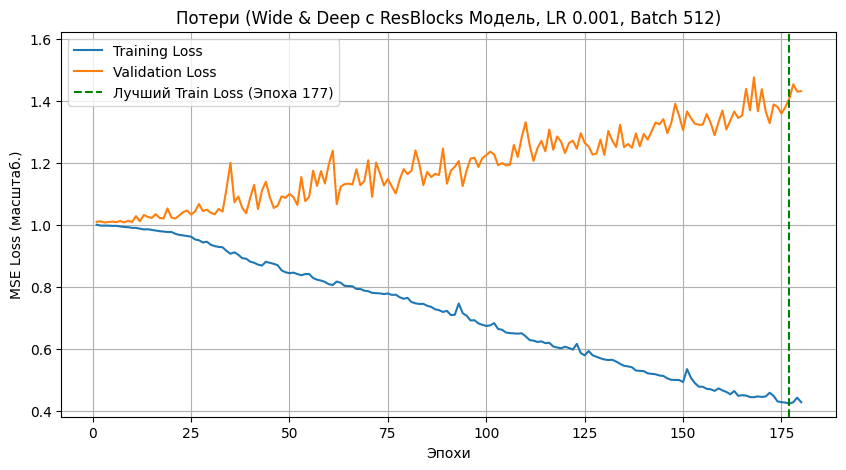

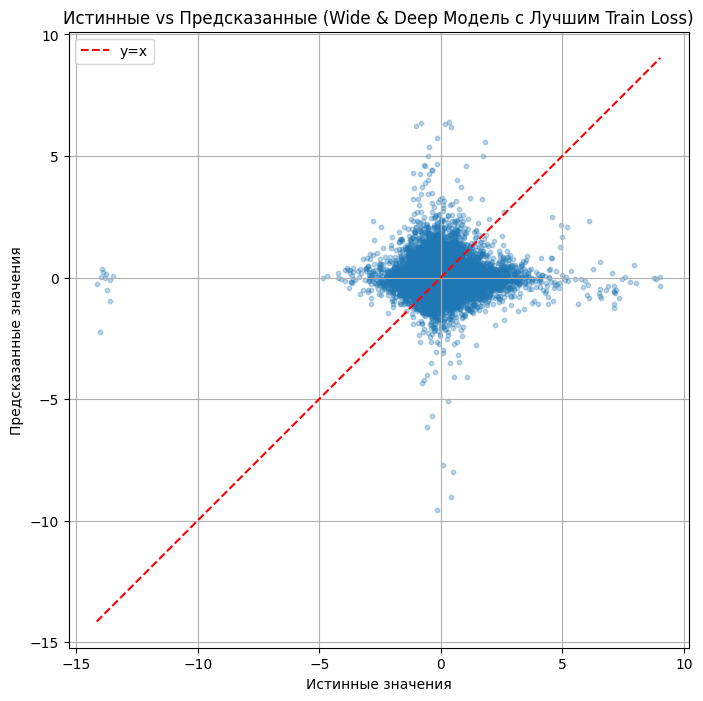


Скрипт завершен.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Убраны импорты Scheduler и EarlyStopping
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# Убран класс EarlyStopping

# --- Класс для Residual Block (остается как был) ---
class ResidualBlock(nn.Module):
    """Остаточный блок: Linear -> BN -> ReLU -> Linear -> BN + Shortcut"""
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)
        if input_dim != output_dim:
            self.shortcut = nn.Sequential(nn.Linear(input_dim, output_dim, bias=False), nn.BatchNorm1d(output_dim))
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.linear1(x)
        if out.shape[0] > 1: out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        if out.shape[0] > 1: out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# --- Класс для Wide & Deep Модели с ResBlocks в Deep части ---
class WideAndDeepWithResBlocks(nn.Module):
    def __init__(self, input_dim, h_initial, h_b1, h_b2, h_b3, h_b4, wide_output_dim, final_hidden_dim, output_dim):
        super(WideAndDeepWithResBlocks, self).__init__()

        # --- Deep Path ---
        self.initial_deep = nn.Sequential(nn.Linear(input_dim, h_initial), nn.BatchNorm1d(h_initial), nn.ReLU())
        self.resblock1 = ResidualBlock(h_initial, h_b1) # h_initial -> h_b1
        self.resblock2 = ResidualBlock(h_b1, h_b2)       # h_b1 -> h_b2
        self.resblock3 = ResidualBlock(h_b2, h_b3)       # h_b2 -> h_b3
        self.resblock4 = ResidualBlock(h_b3, h_b4)       # h_b3 -> h_b4
        self.deep_output_dim = h_b4 # Размерность выхода глубокой части

        # --- Wide Path ---
        self.wide_layer = nn.Linear(input_dim, wide_output_dim)
        self.wide_output_dim = wide_output_dim

        # --- Combined Path ---
        # Размерность после конкатенации
        combined_input_dim = self.deep_output_dim + self.wide_output_dim
        # Добавляем еще один скрытый слой перед выходом для лучшего смешивания
        self.final_hidden_layer = nn.Sequential(
            nn.Linear(combined_input_dim, final_hidden_dim),
            nn.ReLU()
            # Можно добавить BN и сюда nn.BatchNorm1d(final_hidden_dim),
        )
        self.output_layer = nn.Linear(final_hidden_dim, output_dim)

    def forward(self, x):
        # Deep path
        deep_out = self.initial_deep(x)
        deep_out = self.resblock1(deep_out)
        deep_out = self.resblock2(deep_out)
        deep_out = self.resblock3(deep_out)
        deep_out = self.resblock4(deep_out)

        # Wide path
        wide_out = self.wide_layer(x)

        # Combine
        combined = torch.cat((deep_out, wide_out), dim=1)

        # Final layers
        final_hidden = self.final_hidden_layer(combined)
        final_output = self.output_layer(final_hidden)
        return final_output

# --- Configuration ---


DATA_FILE_PATH = '0moex_qcml_final_dataset_with_embeddings.parquet'
TARGET_COLUMN = 'FinalTarget'; DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Wide & Deep с ResBlocks)
INPUT_DIM = -1
# Размеры для Deep части (ResBlocks)
H_INITIAL = 128
H_BLOCK1_OUT = 128
H_BLOCK2_OUT = 64
H_BLOCK3_OUT = 32
H_BLOCK4_OUT = 16 # Выход Deep части будет 16
# Размерность Wide части
WIDE_OUTPUT_DIM = 16
# Размерность слоя после объединения
FINAL_HIDDEN_DIM = 32 # Например, 16+16 -> 32
OUTPUT_DIM = 1
# Параметры обучения
LEARNING_RATE = 0.01
BATCH_SIZE = 512
EPOCHS = 180

# Путь для сохранения лучшей ТРЕНИРОВОЧНОЙ модели
BEST_TRAIN_MODEL_PATH = 'best_train_loss_wide_deep_resnet_model.pt' # Новое имя

# --- Phase 1, 2, 3 (Без изменений) ---
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
# ... (код загрузки, проверки, сортировки, разбиения, масштабирования) ...
if not os.path.exists(DATA_FILE_PATH): print(f"ОШИБКА: Файл не найден {DATA_FILE_PATH}"); raise FileNotFoundError
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet: {e}"); raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN];
if not all(col in df.columns for col in required_cols): print(f"ОШИБКА: Отсутствуют столбцы: {[c for c in required_cols if c not in df.columns]}"); raise ValueError
else: print(f"Столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]];
if not feature_columns: print("ОШИБКА: Нет признаков."); raise ValueError
INPUT_DIM = len(feature_columns); print(f"Найдено {INPUT_DIM} столбцов-признаков.")
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: print(f"ОШИБКА конвертации '{DATE_COLUMN}': {e}"); raise
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True); print(f"Данные отсортированы.")
split_idx = int(len(df) * 0.9); last_train_date = df.loc[split_idx - 1, DATE_COLUMN]
actual_split_idx = (df[DATE_COLUMN] > last_train_date).idxmax()
if actual_split_idx == 0 and split_idx > 0 : actual_split_idx = split_idx
train_df = df.iloc[:actual_split_idx].copy(); test_df = df.iloc[actual_split_idx:].copy()
if train_df.empty or test_df.empty: print(f"ОШИБКА: Пустой датасет после разбиения! Индекс: {actual_split_idx}"); raise ValueError
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные: {len(train_df)} ({train_start} - {train_end})"); print(f"Тестовые: {len(test_df)} ({test_start} - {test_end})")
if train_end < test_start: print("Хронологическое разбиение успешно.")
elif train_end == test_start: print("ВНИМАНИЕ: Граница разбиения по одной дате.")
else: print(f"ОШИБКА: Перекрытие дат! {train_end} vs {test_start}")
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print(f"Цель (трейн) после масштабирования: mean={np.mean(y_train_scaled):.4f}, std={np.std(y_train_scaled):.4f}")
print(f"Цель (тест) после масштабирования: mean={np.mean(y_test_scaled):.4f}, std={np.std(y_test_scaled):.4f}")

# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor); test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем Wide & Deep модель
model = WideAndDeepWithResBlocks(
    input_dim=INPUT_DIM,
    h_initial=H_INITIAL,
    h_b1=H_BLOCK1_OUT,
    h_b2=H_BLOCK2_OUT,
    h_b3=H_BLOCK3_OUT,
    h_b4=H_BLOCK4_OUT,
    wide_output_dim=WIDE_OUTPUT_DIM,
    final_hidden_dim=FINAL_HIDDEN_DIM,
    output_dim=OUTPUT_DIM
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # LR = 0.001

# Планировщик УБРАН
# Early Stopping УБРАН

# Training Loop
train_losses = []; val_losses = []
best_train_loss = np.Inf
start_time = time.time()
print(f"Начало обучения Wide & Deep модели с ResBlocks, LR={LEARNING_RATE}, BatchSize={BATCH_SIZE}...")

for epoch in range(EPOCHS): # EPOCHS = 200
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Сохранение модели по лучшему Train Loss
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), BEST_TRAIN_MODEL_PATH)
        print(f"*** Новый лучший Train Loss: {best_train_loss:.6f}. Модель сохранена в {BEST_TRAIN_MODEL_PATH} ***")

    # Фаза валидации
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Early Stopping УБРАН

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# Загрузка ЛУЧШЕЙ ТРЕНИРОВОЧНОЙ модели
print(f"Загрузка модели с лучшим Train Loss из {BEST_TRAIN_MODEL_PATH}")
try:
    # Создаем экземпляр правильной модели
    final_model = WideAndDeepWithResBlocks(
        input_dim=INPUT_DIM, h_initial=H_INITIAL, h_b1=H_BLOCK1_OUT, h_b2=H_BLOCK2_OUT,
        h_b3=H_BLOCK3_OUT, h_b4=H_BLOCK4_OUT, wide_output_dim=WIDE_OUTPUT_DIM,
        final_hidden_dim=FINAL_HIDDEN_DIM, output_dim=OUTPUT_DIM
    ).to(device)
    final_model.load_state_dict(torch.load(BEST_TRAIN_MODEL_PATH))
    print("Модель с лучшим Train Loss успешно загружена.")
except FileNotFoundError:
    print(f"Ошибка: Файл {BEST_TRAIN_MODEL_PATH} не найден. Используется последняя модель из цикла.")
    final_model = model
except Exception as e:
     print(f"Ошибка при загрузке модели ({e}). Используется последняя модель из цикла.")
     final_model = model

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (с моделью с лучшим Train Loss) ---")
final_model.eval(); predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device); outputs = final_model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled); y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale); final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale); final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}"); print(f"Тестовый набор MAE: {final_mae:.6f}"); print(f"Тестовый набор R^2: {final_r2:.4f}")


# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")
epochs_ran = len(train_losses); plt.figure(figsize=(10, 5)); plt.plot(range(1, epochs_ran + 1), train_losses, label='Training Loss'); plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss')
best_train_epoch = np.argmin(train_losses) + 1; plt.axvline(best_train_epoch, linestyle='--', color='g', label=f'Лучший Train Loss (Эпоха {best_train_epoch})')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштаб.)'); plt.title('Потери (Wide & Deep с ResBlocks Модель, LR 0.001, Batch 512)')
plt.legend(); plt.grid(True); plt.ylim(bottom=min(train_losses)*0.9 if train_losses else 0, top=max(1.1, max(val_losses) * 1.1) if val_losses else 1.1); plt.show()
plt.figure(figsize=(8, 8)); plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10); plt.xlabel('Истинные значения'); plt.ylabel('Предсказанные значения'); plt.title('Истинные vs Предсказанные (Wide & Deep Модель с Лучшим Train Loss)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max()); plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x'); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()
print("\nСкрипт завершен.")


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Добавляем импорт планировщика обратно
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os
import math # Для Positional Encoding, если понадобится (пока не используем)

# --- Класс Residual Block (остается как был) ---
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_p=0.1): # Добавим Dropout опционально
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_p) # Dropout после первой части
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)
        self.dropout2 = nn.Dropout(dropout_p) # Dropout перед финальным сложением

        if input_dim != output_dim:
            self.shortcut = nn.Sequential(nn.Linear(input_dim, output_dim, bias=False), nn.BatchNorm1d(output_dim))
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.linear1(x)
        if out.shape[0] > 1: out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out) # Применяем Dropout
        out = self.linear2(out)
        if out.shape[0] > 1: out = self.bn2(out)
        out = self.dropout2(out) # Применяем Dropout
        out += identity
        out = self.relu(out)
        return out

# --- Класс Transformer-like Encoder Block ---
class AttentionFeatureEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, dropout_p=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        # 1. Линейная проекция в пространство эмбеддингов
        self.input_proj = nn.Linear(input_dim, embed_dim)
        # 2. Multi-Head Self-Attention
        # Вход для Attention: (SeqLen, Batch, Embed)
        # У нас нет SeqLen, работаем с вектором признаков.
        # Простейший вариант: считаем SeqLen=1
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_p, batch_first=True) # batch_first=True для (Batch, SeqLen=1, Embed)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_p)
        # 3. FeedForward Network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout_p)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        # 1. Project to embedding space
        x_embed = self.input_proj(x) # -> (batch_size, embed_dim)

        # 2. Prepare for Attention (SeqLen=1) and apply Self-Attention
        # Reshape to (batch_size, 1, embed_dim)
        x_att_input = x_embed.unsqueeze(1)
        # Self-attention: query=key=value
        attn_output, _ = self.attention(x_att_input, x_att_input, x_att_input)
        # attn_output shape: (batch_size, 1, embed_dim)

        # Add & Norm 1 (Residual connection)
        x = x_embed + self.dropout1(attn_output.squeeze(1)) # Squeeze back to (batch_size, embed_dim)
        x = self.norm1(x)

        # 3. FeedForward
        ffn_output = self.ffn(x)

        # Add & Norm 2 (Residual connection)
        x = x + self.dropout2(ffn_output)
        x = self.norm2(x) # -> (batch_size, embed_dim)

        return x


# --- Класс Гибридной Модели ---
class HybridAttentionResNet(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, h_res1, h_res2, wide_output_dim, final_hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()

        # --- Attention Path (Замена Initial Layer + первые ResBlocks) ---
        self.attention_encoder = AttentionFeatureEncoder(input_dim, embed_dim, num_heads, ff_dim, dropout_p)
        current_dim = embed_dim # Размерность после attention блока

        # --- Оставшиеся ResBlocks ---
        # Можно добавить пару ResBlocks для дальнейшей обработки
        self.resblock1 = ResidualBlock(current_dim, h_res1, dropout_p)
        current_dim = h_res1
        self.resblock2 = ResidualBlock(current_dim, h_res2, dropout_p)
        current_dim = h_res2
        self.deep_output_dim = current_dim # Размерность выхода глубокой части

        # --- Wide Path ---
        self.wide_layer = nn.Linear(input_dim, wide_output_dim)
        self.wide_output_dim = wide_output_dim

        # --- Combined Path ---
        combined_input_dim = self.deep_output_dim + self.wide_output_dim
        self.final_hidden_layer = nn.Sequential(
            nn.Linear(combined_input_dim, final_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p) # Dropout перед последним слоем
        )
        self.output_layer = nn.Linear(final_hidden_dim, output_dim)

    def forward(self, x):
        # Attention + Deep path
        deep_out = self.attention_encoder(x)
        deep_out = self.resblock1(deep_out)
        deep_out = self.resblock2(deep_out)

        # Wide path
        wide_out = self.wide_layer(x)

        # Combine
        combined = torch.cat((deep_out, wide_out), dim=1)

        # Final layers
        final_hidden = self.final_hidden_layer(combined)
        final_output = self.output_layer(final_hidden)
        return final_output

# --- Configuration ---


DATA_FILE_PATH = '0moex_qcml_final_dataset_with_embeddings.parquet'
TARGET_COLUMN = 'FinalTarget'; DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Hybrid Attention + ResNet)
INPUT_DIM = -1
# Attention Block Params
EMBED_DIM = 128     # Размерность внутреннего представления
NUM_HEADS = 8       # Количество голов внимания
FF_DIM = 256        # Размерность внутреннего слоя FFN в Attention блоке
# ResBlock Params (после Attention)
H_RES1_OUT = 64
H_RES2_OUT = 32     # Выход Deep части будет 32
# Wide Path Params
WIDE_OUTPUT_DIM = 16
# Final Layers Params
FINAL_HIDDEN_DIM = 32 # Например, 32+16 -> 32
OUTPUT_DIM = 1
# Общие параметры
DROPOUT_PROB = 0.15  # Умеренный Dropout
LEARNING_RATE = 0.02 # Осторожный LR
WEIGHT_DECAY = 1e-5  # L2 регуляризация
BATCH_SIZE = 256     # Уменьшаем батч
EPOCHS = 200

# Путь для сохранения лучшей ТРЕНИРОВОЧНОЙ модели
BEST_TRAIN_MODEL_PATH = 'best_train_loss_attention_hybrid_model.pt' # Новое имя

# --- Phase 1, 2, 3 (Без изменений) ---
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
# ... (код загрузки, проверки, сортировки, разбиения, масштабирования) ...
if not os.path.exists(DATA_FILE_PATH): print(f"ОШИБКА: Файл не найден {DATA_FILE_PATH}"); raise FileNotFoundError
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet: {e}"); raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN];
if not all(col in df.columns for col in required_cols): print(f"ОШИБКА: Отсутствуют столбцы: {[c for c in required_cols if c not in df.columns]}"); raise ValueError
else: print(f"Столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]];
if not feature_columns: print("ОШИБКА: Нет признаков."); raise ValueError
INPUT_DIM = len(feature_columns); print(f"Найдено {INPUT_DIM} столбцов-признаков.")
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: print(f"ОШИБКА конвертации '{DATE_COLUMN}': {e}"); raise
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True); print(f"Данные отсортированы.")
split_idx = int(len(df) * 0.9); last_train_date = df.loc[split_idx - 1, DATE_COLUMN]
actual_split_idx = (df[DATE_COLUMN] > last_train_date).idxmax()
if actual_split_idx == 0 and split_idx > 0 : actual_split_idx = split_idx
train_df = df.iloc[:actual_split_idx].copy(); test_df = df.iloc[actual_split_idx:].copy()
if train_df.empty or test_df.empty: print(f"ОШИБКА: Пустой датасет после разбиения! Индекс: {actual_split_idx}"); raise ValueError
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные: {len(train_df)} ({train_start} - {train_end})"); print(f"Тестовые: {len(test_df)} ({test_start} - {test_end})")
if train_end < test_start: print("Хронологическое разбиение успешно.")
elif train_end == test_start: print("ВНИМАНИЕ: Граница разбиения по одной дате.")
else: print(f"ОШИБКА: Перекрытие дат! {train_end} vs {test_start}")
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print(f"Цель (трейн) после масштабирования: mean={np.mean(y_train_scaled):.4f}, std={np.std(y_train_scaled):.4f}")
print(f"Цель (тест) после масштабирования: mean={np.mean(y_test_scaled):.4f}, std={np.std(y_test_scaled):.4f}")


# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor); test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Используем новый BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем ГИБРИДНУЮ модель
model = HybridAttentionResNet(
    input_dim=INPUT_DIM,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    h_res1=H_RES1_OUT,
    h_res2=H_RES2_OUT,
    wide_output_dim=WIDE_OUTPUT_DIM,
    final_hidden_dim=FINAL_HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout_p=DROPOUT_PROB
).to(device)

criterion = nn.MSELoss()
# Оптимизатор с Weight Decay
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) # LR=0.0005, WD=1e-5

# Планировщик LR
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=25, threshold=0.01, verbose=True) # patience=15

# Early Stopping УБРАН

# Training Loop
train_losses = []; val_losses = []
best_train_loss = np.Inf
start_time = time.time()
print(f"Начало обучения Гибридной Attention Модели, LR={LEARNING_RATE}, Batch={BATCH_SIZE}, Dropout={DROPOUT_PROB}...")

for epoch in range(EPOCHS): # EPOCHS = 200
    model.train() # Включаем Dropout для Attention и ResBlocks
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # Опционально: проверка и клиппинг градиентов, если есть подозрение на взрыв
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Сохранение модели по лучшему Train Loss
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), BEST_TRAIN_MODEL_PATH)
        print(f"*** Новый лучший Train Loss: {best_train_loss:.6f}. Модель сохранена в {BEST_TRAIN_MODEL_PATH} ***")

    # Фаза валидации
    model.eval() # Выключаем Dropout
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Шаг планировщика
    scheduler.step(avg_val_loss)

    # Early Stopping УБРАН

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# Загрузка ЛУЧШЕЙ ТРЕНИРОВОЧНОЙ модели
print(f"Загрузка модели с лучшим Train Loss из {BEST_TRAIN_MODEL_PATH}")
try:
    # Создаем экземпляр правильной гибридной модели
    final_model = HybridAttentionResNet(
        input_dim=INPUT_DIM, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, ff_dim=FF_DIM,
        h_res1=H_RES1_OUT, h_res2=H_RES2_OUT, wide_output_dim=WIDE_OUTPUT_DIM,
        final_hidden_dim=FINAL_HIDDEN_DIM, output_dim=OUTPUT_DIM, dropout_p=DROPOUT_PROB
    ).to(device)
    final_model.load_state_dict(torch.load(BEST_TRAIN_MODEL_PATH))
    print("Модель с лучшим Train Loss успешно загружена.")
except FileNotFoundError:
    print(f"Ошибка: Файл {BEST_TRAIN_MODEL_PATH} не найден. Используется последняя модель из цикла.")
    final_model = model # Используем последнюю модель, если сохранение не удалось
except Exception as e:
     print(f"Ошибка при загрузке модели ({e}). Используется последняя модель из цикла.")
     final_model = model

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (с моделью с лучшим Train Loss) ---")
final_model.eval(); predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device); outputs = final_model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled); y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale); final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale); final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}"); print(f"Тестовый набор MAE: {final_mae:.6f}"); print(f"Тестовый набор R^2: {final_r2:.4f}")


# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")
epochs_ran = len(train_losses); plt.figure(figsize=(10, 5)); plt.plot(range(1, epochs_ran + 1), train_losses, label='Training Loss'); plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss')
best_train_epoch = np.argmin(train_losses) + 1; plt.axvline(best_train_epoch, linestyle='--', color='g', label=f'Лучший Train Loss (Эпоха {best_train_epoch})')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштаб.)'); plt.title('Потери (Гибридная Attention+ResNet Модель)')
plt.legend(); plt.grid(True); plt.ylim(bottom=min(train_losses)*0.9 if train_losses else 0, top=max(1.1, max(val_losses) * 1.1) if val_losses else 1.1); plt.show()
plt.figure(figsize=(8, 8)); plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10); plt.xlabel('Истинные значения'); plt.ylabel('Предсказанные значения'); plt.title('Истинные vs Предсказанные (Гибридная Модель с Лучшим Train Loss)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max()); plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x'); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()
print("\nСкрипт завершен.")

Попытка загрузить данные из: 0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков.

--- Сортировка и разбиение данных ---
Данные отсортированы.
Тренировочные: 150851 (2021-04-20 00:00:00 - 2024-11-18 00:00:00)
Тестовые: 16735 (2024-11-25 00:00:00 - 2025-03-27 00:00:00)
Хронологическое разбиение успешно.

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков...
Применение масштабировщиков...
Цель (трейн) после масштабирования: mean=0.0000, std=1.0000
Цель (тест) после масштабирования: mean=-0.0069, std=1.0036

--- Определение и Обучение Модели ---
Используемое устройство: cpu
Начало обучения Гибридной Attention Модели, LR=0.02, Batch=256, Dropout=0.15...
*** Новый лучший Train Loss: 1.002019. Модель сохранена в best_train_loss_attention_hybrid_model.pt ***
Эпоха [1/200], Train Loss: 1.002019, Val Loss: 1.007157, LR: 0.0200000
*** Новый лучший Train Loss: 

Попытка загрузить данные из: 0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Обязательные столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков:

--- Сортировка и разбиение данных ---
Данные отсортированы по 'TRADEDATE'.
Тренировочные данные: 150827 семплов, с 2021-04-20 00:00:00 по 2024-11-18 00:00:00
Тестовые данные     : 16759 семплов, с 2024-11-18 00:00:00 по 2025-03-27 00:00:00
ВНИМАНИЕ: Возможно перекрытие дат!

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков...
Применение масштабировщиков...
Данные масштабированы.

--- Определение и Обучение Модели (Transformer-based) ---
Используемое устройство: cuda
Начало обучения...
Эпоха [1/100], Train Loss: 1.490173, Val Loss: 1.008107, LR: 0.0300000
Эпоха [2/100], Train Loss: 1.003331, Val Loss: 1.007450, LR: 0.0300000
Эпоха [3/100], Train Loss: 1.002221, Val Loss: 1.008471, LR: 0.0300000
Эпоха [4/100], Train Loss: 1.002716, Val Loss: 1.007344, LR: 

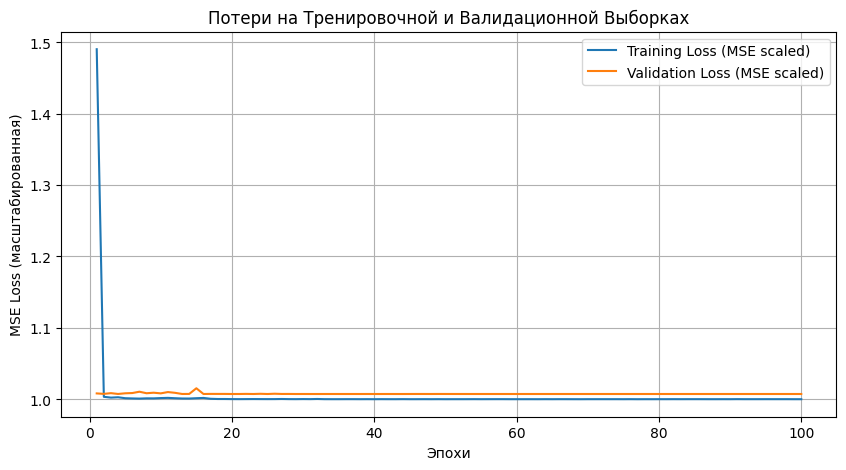

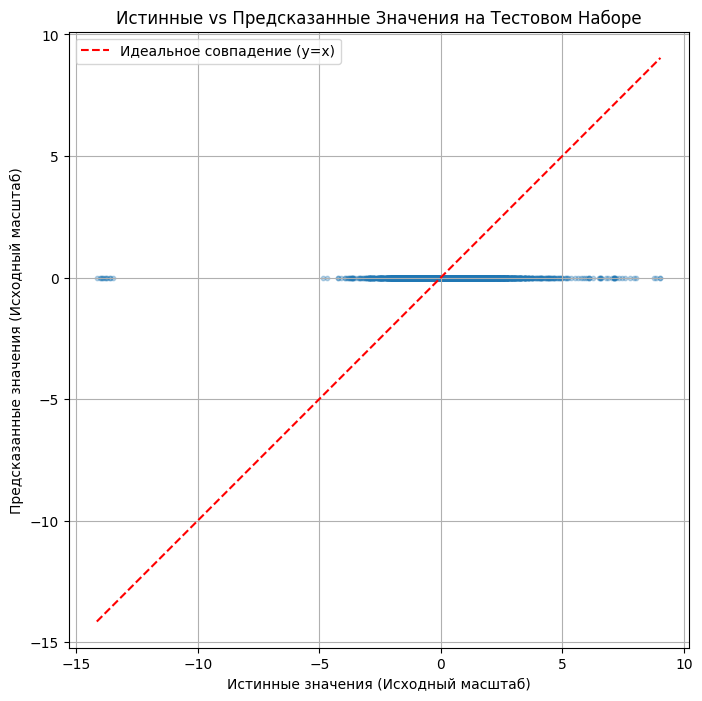


Скрипт завершен.


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import math # Для позиционного кодирования (опционально, но может помочь)
import os

# --- Configuration ---
# Try to mount Google Drive

DATA_FILE_PATH = '0moex_qcml_final_dataset_with_embeddings.parquet'
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Transformer-inspired)
INPUT_DIM = -1      # Определяется после загрузки данных
EMBED_DIM = 128     # Размерность внутреннего представления (вложения)
NUM_HEADS = 8       # Количество "голов" внимания (должно делить EMBED_DIM)
NUM_TF_LAYERS = 2   # Количество блоков Transformer (Attention + FeedForward)
DIM_FEEDFORWARD = 512 # Размерность скрытого слоя в FeedForward блоке Transformer
DROPOUT_RATE = 0.1  # Dropout для регуляризации
OUTPUT_DIM = 1

LEARNING_RATE = 0.03 # Начальный шаг обучения
BATCH_SIZE = 2048
EPOCHS = 100 # Увеличиваем количество эпох для сложной модели

# --- Phase 1: Setup & Data Loading ---
# (Остается без изменений, как в предыдущей версии)
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
if not os.path.exists(DATA_FILE_PATH):
    print(f"ОШИБКА: Файл данных не найден по пути {DATA_FILE_PATH}")
    # ... (dummy data generation) ...
    print("Создание dummy-данных для демонстрации...")
    num_samples = 10000
    num_features = 15 # Примерное количество признаков
    num_days = 100
    stocks_per_day = num_samples // num_days
    dummy_data = {
        DATE_COLUMN: np.repeat(pd.date_range('2010-01-01', periods=num_days, freq='B').astype(np.int64) // 10**9, stocks_per_day) * 1_000_000_000, # Nanoseconds
        TARGET_COLUMN: np.random.randn(num_samples),
    }
    for i in range(num_features):
        dummy_data[f'feature_{i+1}'] = np.random.randn(num_samples)
    df = pd.DataFrame(dummy_data)
    print("Dummy-данные созданы.")
else:
    try:
        df = pd.read_parquet(DATA_FILE_PATH)
        print("Данные успешно загружены.")
    except Exception as e:
        print(f"ОШИБКА: Не удалось загрузить Parquet файл: {e}")
        raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]
missing_req = [col for col in required_cols if col not in df.columns]
if missing_req: raise ValueError(f"Отсутствуют обязательные столбцы: {missing_req}")
print(f"Обязательные столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns: raise ValueError("Нет признаков для обучения")
INPUT_DIM = len(feature_columns)
print(f"Найдено {INPUT_DIM} столбцов-признаков:")
# print(feature_columns)

# --- Phase 2: Initial Time Sort & Data Splitting ---
# (Остается без изменений)
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: raise ValueError(f"Не удалось конвертировать '{DATE_COLUMN}': {e}")
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
print(f"Данные отсортированы по '{DATE_COLUMN}'.")
split_idx = int(len(df) * 0.9)
train_df = df.iloc[:split_idx].copy(); test_df = df.iloc[split_idx:].copy()
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные данные: {len(train_df)} семплов, с {train_start} по {train_end}")
print(f"Тестовые данные     : {len(test_df)} семплов, с {test_start} по {test_end}")
if train_end >= test_start: print(f"ВНИМАНИЕ: Возможно перекрытие дат!")

# --- Phase 3: Preprocessing (Scaling) ---
# (Остается без изменений)
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print("Данные масштабированы.")

# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели (Transformer-based) ---")

# Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the Transformer-based Model
class AttentionNN(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dim_feedforward, output_dim, dropout=0.1):
        super(AttentionNN, self).__init__()
        self.initial_embedding = nn.Linear(input_dim, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout) # Опционально, но может помочь

        # Используем стандартный TransformerEncoderLayer
        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim,
                                                     nhead=num_heads,
                                                     dim_feedforward=dim_feedforward,
                                                     dropout=dropout,
                                                     batch_first=True) # Важно: Ожидает (batch, seq, feature)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.output_layer = nn.Linear(embed_dim, output_dim)
        self.embed_dim = embed_dim

    def forward(self, src):
        # src shape: (batch_size, input_dim)
        src = self.initial_embedding(src) * math.sqrt(self.embed_dim) # shape: (batch_size, embed_dim)
        # Добавляем фиктивную 'sequence' размерность для TransformerEncoderLayer
        # Transformer ожидает (batch, seq_len, features)
        src = src.unsqueeze(1) # shape: (batch_size, 1, embed_dim)
        # src = self.pos_encoder(src) # Применяем позиционное кодирование

        # Прогоняем через слои трансформера
        output = self.transformer_encoder(src) # shape: (batch_size, 1, embed_dim)

        # Убираем фиктивную размерность
        output = output.squeeze(1) # shape: (batch_size, embed_dim)

        # Финальный слой для получения предсказания
        output = self.output_layer(output) # shape: (batch_size, output_dim)
        return output

# Дополнительный класс для позиционного кодирования (стандартный из туториалов PyTorch)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000): # max_len можно адаптировать
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        # Переносим pe на buffer, чтобы он не считался параметром модели, но сохранялся вместе с ней
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
               В нашем случае seq_len = 1
        """
        # Добавляем позиционное кодирование к вложениям
        # self.pe[:x.size(1)] требует seq_len > 0
        # Для seq_len=1, нам нужно извлечь только первое кодирование
        # И применить его к каждому элементу батча
        # x = x + self.pe[:x.size(1)].transpose(0,1) # Оригинал для seq_len > 1
        if x.size(1) > 0:
             # Используем .transpose(0,1) для [1, batch_size, embed_dim] -> [batch_size, 1, embed_dim]
             # И берем только первое поз. кодирование self.pe[0] -> [1, embed_dim]
             # Расширяем до [1, 1, embed_dim] для сложения
             pos_encoding = self.pe[0].unsqueeze(0) # shape [1, 1, embed_dim]
             x = x + pos_encoding # Broadcasting добавит его ко всем элементам батча

        return self.dropout(x)


# Instantiate model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем экземпляр новой AttentionNN модели
model = AttentionNN(input_dim=INPUT_DIM,
                    embed_dim=EMBED_DIM,
                    num_heads=NUM_HEADS,
                    num_layers=NUM_TF_LAYERS,
                    dim_feedforward=DIM_FEEDFORWARD,
                    output_dim=OUTPUT_DIM,
                    dropout=DROPOUT_RATE).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Создаем планировщик learning rate с увеличенным терпением
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.1,
                              patience=15, # Увеличено до 10
                              threshold=0.1,
                              verbose=True)

# --- Training Loop ---
train_losses = []
val_losses = []
start_time = time.time()

print("Начало обучения...")
for epoch in range(EPOCHS): # Увеличено количество эпох
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    scheduler.step(avg_val_loss)

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")


# --- Phase 5: Prediction & Final Evaluation ---
# (Остается без изменений)
print("\n--- Предсказание и Финальная Оценка ---")
model.eval()
predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled)
y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}")
print(f"Тестовый набор MAE: {final_mae:.6f}")
print(f"Тестовый набор R^2: {final_r2:.4f}")


# --- Phase 6: Visualization ---
# (Остается без изменений)
print("\n--- Построение Графиков ---")
# 1. Кривая обучения (Потери)
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss (MSE scaled)')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss (MSE scaled)')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштабированная)')
plt.title('Потери на Тренировочной и Валидационной Выборках'); plt.legend(); plt.grid(True); plt.show()
# 2. График "Истинные vs Предсказанные значения"
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения (Исходный масштаб)'); plt.ylabel('Предсказанные значения (Исходный масштаб)')
plt.title('Истинные vs Предсказанные Значения на Тестовом Наборе')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное совпадение (y=x)')
plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()

print("\nСкрипт завершен.")

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Убираем импорт планировщика
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# Добавляем утилиту для обрезки градиентов
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler # Или RobustScaler
# from sklearn.preprocessing import RobustScaler # Вариант для пробы
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import math
import os

# --- Configuration ---
# Try to mount Google Drive


DATA_FILE_PATH = '0moex_qcml_final_dataset_with_embeddings.parquet'
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Transformer-inspired, adjusted)
INPUT_DIM = -1
EMBED_DIM = 128
NUM_HEADS = 8
NUM_TF_LAYERS = 3   # Уменьшено до 1 слоя для отладки
DIM_FEEDFORWARD = 512
DROPOUT_RATE = 0.0
OUTPUT_DIM = 1

# Значительно уменьшаем LR, добавляем weight_decay
LEARNING_RATE = 1e-4 # Было 0.001
WEIGHT_DECAY = 1e-4 # Добавлена L2 регуляризация
GRADIENT_CLIP_VALUE = 1.0 # Максимальная норма градиента

BATCH_SIZE = 2048
EPOCHS = 100 # Оставляем 100 эпох, т.к. LR маленький

# --- Phase 1: Setup & Data Loading ---
# (Без изменений)
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
if not os.path.exists(DATA_FILE_PATH):
    print(f"ОШИБКА: Файл данных не найден по пути {DATA_FILE_PATH}")
    # ... (dummy data generation) ...
    print("Создание dummy-данных для демонстрации...")
    num_samples = 10000; num_features = 15; num_days = 100; stocks_per_day = num_samples // num_days
    dummy_data = { DATE_COLUMN: np.repeat(pd.date_range('2010-01-01', periods=num_days, freq='B').astype(np.int64) // 10**9, stocks_per_day) * 1_000_000_000, TARGET_COLUMN: np.random.randn(num_samples),}
    for i in range(num_features): dummy_data[f'feature_{i+1}'] = np.random.randn(num_samples)
    df = pd.DataFrame(dummy_data)
    print("Dummy-данные созданы.")
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet файл: {e}"); raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]
missing_req = [col for col in required_cols if col not in df.columns]
if missing_req: raise ValueError(f"Отсутствуют обязательные столбцы: {missing_req}")
print(f"Обязательные столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns: raise ValueError("Нет признаков для обучения")
INPUT_DIM = len(feature_columns)
print(f"Найдено {INPUT_DIM} столбцов-признаков:")
# print(feature_columns)

# --- Phase 2: Initial Time Sort & Data Splitting ---
# (Без изменений)
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: raise ValueError(f"Не удалось конвертировать '{DATE_COLUMN}': {e}")
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
print(f"Данные отсортированы по '{DATE_COLUMN}'.")
split_idx = int(len(df) * 0.9); train_df = df.iloc[:split_idx].copy(); test_df = df.iloc[split_idx:].copy()
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные данные: {len(train_df)} семплов, с {train_start} по {train_end}")
print(f"Тестовые данные     : {len(test_df)} семплов, с {test_start} по {test_end}")
if train_end >= test_start: print(f"ВНИМАНИЕ: Возможно перекрытие дат!")

# --- Phase 3: Preprocessing (Scaling) ---
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
# Используем StandardScaler, но можно попробовать RobustScaler
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
# feature_scaler = RobustScaler(); target_scaler = RobustScaler() # Вариант
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print("Данные масштабированы.")

# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели (Transformer-based, Adjusted) ---")

# Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the Transformer-based Model (Positional Encoding опционально)
class AttentionNN(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dim_feedforward, output_dim, dropout=0.1):
        super(AttentionNN, self).__init__()
        self.initial_embedding = nn.Linear(input_dim, embed_dim)
        # self.pos_encoder = PositionalEncoding(embed_dim, dropout) # Опционально

        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim,
                                                     nhead=num_heads,
                                                     dim_feedforward=dim_feedforward,
                                                     dropout=dropout,
                                                     batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.output_layer = nn.Linear(embed_dim, output_dim)
        self.embed_dim = embed_dim

    def forward(self, src):
        src = self.initial_embedding(src) * math.sqrt(self.embed_dim)
        src = src.unsqueeze(1) # Add sequence dimension: (batch, 1, embed_dim)
        # src = self.pos_encoder(src) # Optional
        output = self.transformer_encoder(src)
        output = output.squeeze(1) # Remove sequence dimension: (batch, embed_dim)
        output = self.output_layer(output)
        return output

# Positional Encoding (если решите использовать)
class PositionalEncoding(nn.Module):
    # ... (код PositionalEncoding остается как был) ...
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        if x.size(1) > 0:
            pos_encoding = self.pe[0].unsqueeze(0)
            x = x + pos_encoding
        return self.dropout(x)

# Instantiate model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем модель (NUM_TF_LAYERS=1)
model = AttentionNN(input_dim=INPUT_DIM,
                    embed_dim=EMBED_DIM,
                    num_heads=NUM_HEADS,
                    num_layers=NUM_TF_LAYERS, # Используем 1 слой
                    dim_feedforward=DIM_FEEDFORWARD,
                    output_dim=OUTPUT_DIM,
                    dropout=DROPOUT_RATE).to(device)

criterion = nn.MSELoss()
# Используем Adam с низким LR и weight_decay
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# Убираем планировщик
# scheduler = ReduceLROnPlateau(...)

# --- Training Loop ---
train_losses = []
val_losses = []
start_time = time.time()

print("Начало обучения...")
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # Добавляем обрезку градиентов
        clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_VALUE)
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    # Выводим LR (он теперь будет постоянным)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Убираем шаг планировщика
    # scheduler.step(avg_val_loss)

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# --- Phase 5: Prediction & Final Evaluation ---
# (Без изменений)
print("\n--- Предсказание и Финальная Оценка ---")
model.eval()
predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled)
y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}")
print(f"Тестовый набор MAE: {final_mae:.6f}")
print(f"Тестовый набор R^2: {final_r2:.4f}")

# --- Phase 6: Visualization ---
# (Без изменений)
print("\n--- Построение Графиков ---")
# 1. Кривая обучения (Потери)
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss (MSE scaled)')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss (MSE scaled)')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштабированная)')
plt.title('Потери на Тренировочной и Валидационной Выборках'); plt.legend(); plt.grid(True); plt.show()
# 2. График "Истинные vs Предсказанные значения"
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения (Исходный масштаб)'); plt.ylabel('Предсказанные значения (Исходный масштаб)')
plt.title('Истинные vs Предсказанные Значения на Тестовом Наборе')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное совпадение (y=x)')
plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()

print("\nСкрипт завершен.")

Попытка загрузить данные из: 0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Обязательные столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков:

--- Сортировка и разбиение данных ---
Данные отсортированы по 'TRADEDATE'.
Тренировочные данные: 150827 семплов, с 2021-04-20 00:00:00 по 2024-11-18 00:00:00
Тестовые данные     : 16759 семплов, с 2024-11-18 00:00:00 по 2025-03-27 00:00:00
ВНИМАНИЕ: Возможно перекрытие дат!

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков...
Применение масштабировщиков...
Данные масштабированы.

--- Определение и Обучение Модели (Transformer-based, Adjusted) ---
Используемое устройство: cuda
Начало обучения...
Эпоха [1/100], Train Loss: 1.011851, Val Loss: 1.013102, LR: 0.0001000
Эпоха [2/100], Train Loss: 0.999486, Val Loss: 1.012496, LR: 0.0001000
Эпоха [3/100], Train Loss: 0.996695, Val Loss: 1.014174, LR: 0.0001000
Эпоха [4/100], Train Loss: 0.992509, Val Loss: 1.01

ValueError: Input contains NaN.

Попытка загрузить данные из: 0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Обязательные столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков:

--- Сортировка и разбиение данных ---
Данные отсортированы по 'TRADEDATE'.
Тренировочные данные: 150827 семплов, с 2021-04-20 00:00:00 по 2024-11-18 00:00:00
Тестовые данные     : 16759 семплов, с 2024-11-18 00:00:00 по 2025-03-27 00:00:00
ВНИМАНИЕ: Возможно перекрытие дат!

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков...
Применение масштабировщиков...
Данные масштабированы.

--- Определение и Обучение Модели (Возврат к MLP) ---
Используемое устройство: cuda
Начало обучения...
Эпоха [1/100], Train Loss: 1.399523, Val Loss: 1.376001, LR: 0.0001000
Эпоха [2/100], Train Loss: 1.329126, Val Loss: 1.346788, LR: 0.0001000
Эпоха [3/100], Train Loss: 1.304027, Val Loss: 1.335700, LR: 0.0001000
Эпоха [4/100], Train Loss: 1.292208, Val Loss: 1.331556, LR: 0.00

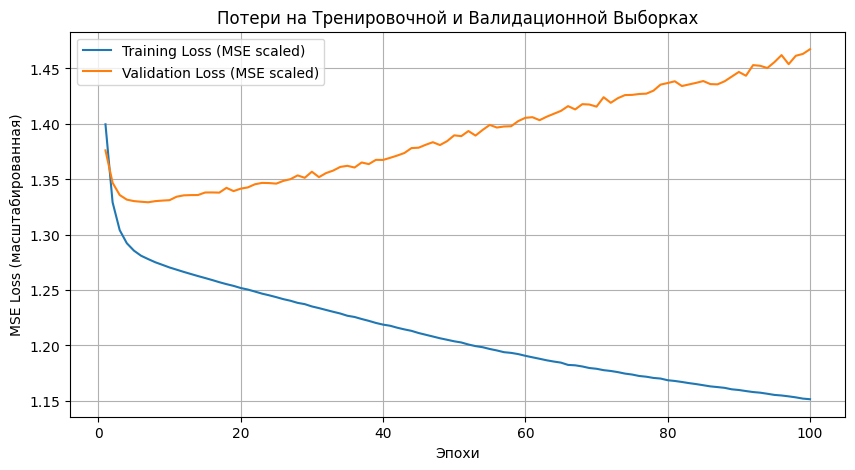

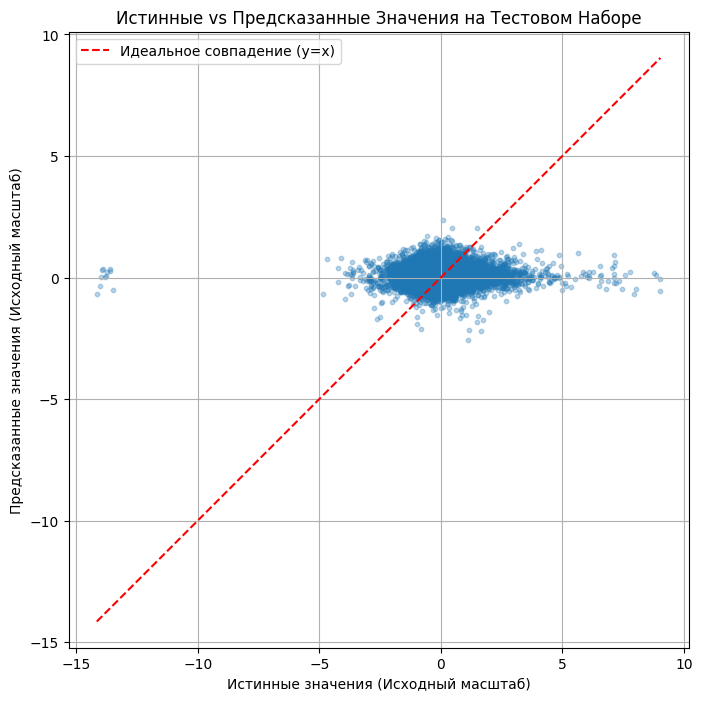


Скрипт завершен.


In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Убираем планировщик, если он еще импортирован
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# Утилита для обрезки градиентов остается
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, TensorDataset
# ИЗМЕНЕНИЕ: Используем RobustScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
# Убираем math, т.к. PositionalEncoding не используется
# import math
import os

# --- Configuration ---
# Try to mount Google Drive


DATA_FILE_PATH = '0moex_qcml_final_dataset_with_embeddings.parquet'
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Возвращаемся к MLP)
INPUT_DIM = -1
# Параметры для MLP (4 скрытых слоя)
HIDDEN_DIM1 = 128
HIDDEN_DIM2 = 64
HIDDEN_DIM3 = 32
HIDDEN_DIM4 = 16
OUTPUT_DIM = 1

# Оставляем настройки оптимизации, которые пробовали для Transformer
LEARNING_RATE = 1e-4 # Низкий LR
WEIGHT_DECAY = 1e-4 # Регуляризация
GRADIENT_CLIP_VALUE = 1.0 # Обрезка градиентов

BATCH_SIZE = 2048
EPOCHS = 100 # Оставляем 100 эпох

# --- Phase 1: Setup & Data Loading ---
# (Без изменений)
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
if not os.path.exists(DATA_FILE_PATH):
    print(f"ОШИБКА: Файл данных не найден по пути {DATA_FILE_PATH}")
    # ... (dummy data generation) ...
    print("Создание dummy-данных для демонстрации...")
    num_samples = 10000; num_features = 18; num_days = 100; stocks_per_day = num_samples // num_days # Используем ваши 18 признаков
    dummy_data = { DATE_COLUMN: np.repeat(pd.date_range('2010-01-01', periods=num_days, freq='B').astype(np.int64) // 10**9, stocks_per_day) * 1_000_000_000, TARGET_COLUMN: np.random.randn(num_samples),}
    for i in range(num_features): dummy_data[f'feature_{i+1}'] = np.random.randn(num_samples)
    df = pd.DataFrame(dummy_data)
    print("Dummy-данные созданы.")
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet файл: {e}"); raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]
missing_req = [col for col in required_cols if col not in df.columns]
if missing_req: raise ValueError(f"Отсутствуют обязательные столбцы: {missing_req}")
print(f"Обязательные столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns: raise ValueError("Нет признаков для обучения")
INPUT_DIM = len(feature_columns)
print(f"Найдено {INPUT_DIM} столбцов-признаков:")
# print(feature_columns)

# --- Phase 2: Initial Time Sort & Data Splitting ---
# (Без изменений)
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: raise ValueError(f"Не удалось конвертировать '{DATE_COLUMN}': {e}")
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
print(f"Данные отсортированы по '{DATE_COLUMN}'.")
split_idx = int(len(df) * 0.9); train_df = df.iloc[:split_idx].copy(); test_df = df.iloc[split_idx:].copy()
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные данные: {len(train_df)} семплов, с {train_start} по {train_end}")
print(f"Тестовые данные     : {len(test_df)} семплов, с {test_start} по {test_end}")
if train_end >= test_start: print(f"ВНИМАНИЕ: Возможно перекрытие дат!")

# --- Phase 3: Preprocessing (Scaling) ---
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]

# ИЗМЕНЕНИЕ: Используем RobustScaler
feature_scaler = RobustScaler(); target_scaler = RobustScaler()

print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print("Данные масштабированы.")

# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели (Возврат к MLP) ---")

# Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ИЗМЕНЕНИЕ: Используем предыдущую MLP модель
class ClassicalNN(nn.Module):
    # Используем h1, h2, h3, h4 из конфигурации
    def __init__(self, input_dim, h1, h2, h3, h4, output_dim):
        super(ClassicalNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(h2, h3)
        self.bn3 = nn.BatchNorm1d(h3)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.Linear(h3, h4)
        self.bn4 = nn.BatchNorm1d(h4)
        self.relu4 = nn.ReLU()
        self.output_layer = nn.Linear(h4, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        if x.shape[0] > 1: x = self.bn1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        if x.shape[0] > 1: x = self.bn2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        if x.shape[0] > 1: x = self.bn3(x)
        x = self.relu3(x)
        x = self.layer4(x)
        if x.shape[0] > 1: x = self.bn4(x)
        x = self.relu4(x)
        x = self.output_layer(x)
        return x

# Instantiate model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем экземпляр MLP модели
model = ClassicalNN(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, HIDDEN_DIM4, OUTPUT_DIM).to(device)

criterion = nn.MSELoss()
# Оставляем Adam с низким LR и weight_decay
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# Планировщик все еще убран

# --- Training Loop ---
train_losses = []
val_losses = []
start_time = time.time()

print("Начало обучения...")
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # Применяем обрезку градиентов
        clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_VALUE)
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")
    # Шаг планировщика убран

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# --- Phase 5: Prediction & Final Evaluation ---
# (Без изменений)
print("\n--- Предсказание и Финальная Оценка ---")
model.eval()
predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
# Используем RobustScaler для обратного преобразования
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled)
y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}")
print(f"Тестовый набор MAE: {final_mae:.6f}")
print(f"Тестовый набор R^2: {final_r2:.4f}")

# --- Phase 6: Visualization ---
# (Без изменений)
print("\n--- Построение Графиков ---")
# 1. Кривая обучения (Потери)
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss (MSE scaled)')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss (MSE scaled)')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштабированная)')
plt.title('Потери на Тренировочной и Валидационной Выборках'); plt.legend(); plt.grid(True); plt.show()
# 2. График "Истинные vs Предсказанные значения"
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения (Исходный масштаб)'); plt.ylabel('Предсказанные значения (Исходный масштаб)')
plt.title('Истинные vs Предсказанные Значения на Тестовом Наборе')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное совпадение (y=x)')
plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()

print("\nСкрипт завершен.")

In [3]:
pip install pytorch-tabnet

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
 # '-q' делает вывод менее подробным

# --- Основные импорты ---
import pandas as pd
import numpy as np
import torch
# import torch.nn as nn # Убрали кастомную модель
import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau # Убрали
# from torch.nn.utils import clip_grad_norm_ # Убрали
from torch.utils.data import DataLoader, TensorDataset
# ИМПОРТИРУЕМ TabNetRegressor
from pytorch_tabnet.tab_model import TabNetRegressor # Теперь должно сработать
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# --- Configuration ---
# Try to mount Google Drive


DATA_FILE_PATH = '0moex_qcml_final_dataset_with_embeddings.parquet'
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# --- TabNet Hyperparameters ---
# (Это примерные параметры, их нужно будет тюнить)
TABNET_N_D = 32          # Размерность пространства признаков на каждом шаге
TABNET_N_A = 32          # Размерность пространства внимания на каждом шаге
TABNET_N_STEPS = 4       # Количество шагов принятия решения
TABNET_GAMMA = 1.3       # Коэффициент для масок внимания
TABNET_N_INDEPENDENT = 4 # Количество независимых GLU слоев
TABNET_N_SHARED = 3      # Количество общих GLU слоев
TABNET_LAMBDA_SPARSE = 5e-4 # Коэффициент для штрафа за разреженность масок
# Параметры обучения для TabNet (встроенные в .fit)
TABNET_LR = 4e-2         # TabNet часто использует более высокий LR
TABNET_BATCH_SIZE = 2048*8 # И более высокий Batch Size
TABNET_VIRTUAL_BATCH_SIZE = 1024*8 # Для Ghost BatchNorm внутри TabNet
TABNET_EPOCHS = 100      # Максимальное количество эпох

# --- Phase 1: Setup & Data Loading ---
# (Без изменений)
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
if not os.path.exists(DATA_FILE_PATH):
    print(f"ОШИБКА: Файл данных не найден по пути {DATA_FILE_PATH}")
    # ... (dummy data generation) ...
    print("Создание dummy-данных для демонстрации...")
    num_samples = 10000; num_features = 18; num_days = 100; stocks_per_day = num_samples // num_days
    dummy_data = { DATE_COLUMN: np.repeat(pd.date_range('2010-01-01', periods=num_days, freq='B').astype(np.int64) // 10**9, stocks_per_day) * 1_000_000_000, TARGET_COLUMN: np.random.randn(num_samples),}
    for i in range(num_features): dummy_data[f'feature_{i+1}'] = np.random.randn(num_samples)
    df = pd.DataFrame(dummy_data)
    print("Dummy-данные созданы.")
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet файл: {e}"); raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]
missing_req = [col for col in required_cols if col not in df.columns]
if missing_req: raise ValueError(f"Отсутствуют обязательные столбцы: {missing_req}")
print(f"Обязательные столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns: raise ValueError("Нет признаков для обучения")
INPUT_DIM = len(feature_columns) # Все еще нужно для информации
print(f"Найдено {INPUT_DIM} столбцов-признаков:")
# print(feature_columns)

# --- Phase 2: Initial Time Sort & Data Splitting ---
# (Без изменений)
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: raise ValueError(f"Не удалось конвертировать '{DATE_COLUMN}': {e}")
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
print(f"Данные отсортированы по '{DATE_COLUMN}'.")
split_idx = int(len(df) * 0.9); train_df = df.iloc[:split_idx].copy(); test_df = df.iloc[split_idx:].copy()
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные данные: {len(train_df)} семплов, с {train_start} по {train_end}")
print(f"Тестовые данные     : {len(test_df)} семплов, с {test_start} по {test_end}")
if train_end >= test_start: print(f"ВНИМАНИЕ: Возможно перекрытие дат!")

# --- Phase 3: Preprocessing (Scaling) ---
print("\n--- Предобработка (Масштабирование) ---")
# TabNet предпочитает работать с numpy массивами
X_train = train_df[feature_columns].values
y_train = train_df[[TARGET_COLUMN]].values # Оставляем 2D для scaler
X_test = test_df[feature_columns].values
y_test = test_df[[TARGET_COLUMN]].values # Оставляем 2D для scaler

# Используем RobustScaler
scaler = RobustScaler()
# ВАЖНО: TabNet обычно не требует масштабирования цели,
# но если мы хотим сравнивать MSE с предыдущими моделями,
# то лучше оставить масштабирование цели.
# Если целевая переменная имеет очень большой разброс, масштабирование может помочь.
# Давайте попробуем БЕЗ масштабирования цели для начала, как рекомендует TabNet.
target_scaler = None # Убираем масштабирование цели

print("Обучение масштабировщика признаков..."); X_train_scaled = scaler.fit_transform(X_train)
# y_train_scaled = target_scaler.fit_transform(y_train) # Цель не масштабируем
y_train_scaled = y_train # Используем оригинал
print("Применение масштабировщика признаков..."); X_test_scaled = scaler.transform(X_test)
# y_test_scaled = target_scaler.transform(y_test) # Цель не масштабируем
y_test_scaled = y_test # Используем оригинал
print("Признаки масштабированы (цель - нет).")


# --- Phase 4: Model Definition & Training (Using TabNet) ---
print("\n--- Определение и Обучение Модели (TabNet) ---")

# Определяем устройство
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")

# Создаем модель TabNetRegressor
# Передаем гиперпараметры, определенные ранее
model = TabNetRegressor(
    n_d=TABNET_N_D,
    n_a=TABNET_N_A,
    n_steps=TABNET_N_STEPS,
    gamma=TABNET_GAMMA,
    n_independent=TABNET_N_INDEPENDENT,
    n_shared=TABNET_N_SHARED,
    lambda_sparse=TABNET_LAMBDA_SPARSE,
    optimizer_fn=torch.optim.Adam, # Можно указать оптимизатор
    optimizer_params=dict(lr=TABNET_LR), # И его параметры
    mask_type='sparsemax', # 'sparsemax' или 'entmax'
    scheduler_params={"step_size":15, "gamma":0.9}, # Встроенный планировщик
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    device_name=device,
    verbose=5 # Частота вывода логов обучения (каждые 10 эпох)
)

# Обучение модели TabNet
start_time = time.time()
print("Начало обучения TabNet...")

# TabNet использует eval_set для валидации и ранней остановки
# Мы используем наш тестовый набор как валидационный
# Важно: передаем масштабированные X, но ОРИГИНАЛЬНЫЕ y (т.к. не масштабировали)
model.fit(
    X_train=X_train_scaled, y_train=y_train_scaled.reshape(-1, 1), # y_train дб (N, 1)
    eval_set=[(X_train_scaled, y_train_scaled.reshape(-1, 1)), (X_test_scaled, y_test_scaled.reshape(-1, 1))],
    eval_name=['train', 'valid'],
    eval_metric=['rmse', 'mae'], # Метрики для оценки (rmse - корень из mse)
    max_epochs=TABNET_EPOCHS,
    patience=15, # Количество эпох без улучшения на валидации для ранней остановки
    batch_size=TABNET_BATCH_SIZE,
    virtual_batch_size=TABNET_VIRTUAL_BATCH_SIZE,
    num_workers=0, # Можно увеличить для ускорения загрузки данных, если есть CPU ядра
    drop_last=False
)

training_time = time.time() - start_time
print(f"Обучение TabNet завершено за {training_time:.2f} секунд.")

# Получение истории обучения (если нужно для графиков)
train_losses = [ep['loss'] for ep in model.history['train']]
val_rmses = model.history['valid_rmse']
val_losses = [rmse**2 for rmse in val_rmses] # RMSE -> MSE


# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (TabNet) ---")

# Предсказание на тестовом наборе
# Метод predict возвращает numpy массив
predictions_original_scale = model.predict(X_test_scaled)
# y_test_original_scale у нас уже в оригинальном масштабе
y_test_original_scale = y_test_scaled.flatten() # Flatten для метрик

# Оценка модели
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)

print("\n--- Финальные Метрики ---")
print(f"Тестовый набор MSE: {final_mse:.6f}")
print(f"Тестовый набор MAE: {final_mae:.6f}")
print(f"Тестовый набор R^2: {final_r2:.4f}")

# Место: Сразу после завершения обучения model.fit()

# Получение истории обучения (если нужно для графиков)
# ИЗМЕНЕНИЕ: Используем ключ 'loss' для тренировочных потерь
train_losses = model.history['loss']

# ИЗМЕНЕНИЕ: Используем ключ 'valid_rmse' из истории напрямую
# (model.history['valid_rmse'] уже содержит список значений RMSE по эпохам)
# Квадрат возводим для каждого значения в списке

# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")

# 1. Кривая обучения (Потери) - Используем исправленные переменные
plt.figure(figsize=(10, 5))
# Используем train_losses напрямую
plt.plot(train_losses, label='Training Loss (TabNet Internal)')
# Используем посчитанные val_losses (MSE)
plt.plot(val_losses, label='Validation Loss (MSE approx. from RMSE)')
plt.xlabel('Эпохи')
plt.ylabel('Loss / Metric Value')
plt.title('История Обучения TabNet')
plt.legend()
plt.grid(True)
# Логарифмическая шкала может быть полезна, если потери сильно меняются
# plt.yscale('log')
plt.show()

# ... (остальной код для графика "Истинные vs Предсказанные" остается без изменений) ...

# 2. График "Истинные vs Предсказанные значения"
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Истинные vs Предсказанные Значения на Тестовом Наборе (TabNet)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min())
max_val = max(y_test_original_scale.max(), predictions_original_scale.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное совпадение (y=x)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

print("\nСкрипт завершен.")

Попытка загрузить данные из: 0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Обязательные столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков:

--- Сортировка и разбиение данных ---
Данные отсортированы по 'TRADEDATE'.
Тренировочные данные: 150827 семплов, с 2021-04-20 00:00:00 по 2024-11-18 00:00:00
Тестовые данные     : 16759 семплов, с 2024-11-18 00:00:00 по 2025-03-27 00:00:00
ВНИМАНИЕ: Возможно перекрытие дат!

--- Предобработка (Масштабирование) ---
Обучение масштабировщика признаков...
Применение масштабировщика признаков...
Признаки масштабированы (цель - нет).

--- Определение и Обучение Модели (TabNet) ---
Используемое устройство: cuda
Начало обучения TabNet...


/home/jupyter/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.32068 | train_rmse: 1.32604 | train_mae: 0.90607 | valid_rmse: 1.20237 | valid_mae: 0.83967 |  0:00:07s
epoch 5  | loss: 0.98048 | train_rmse: 0.98921 | train_mae: 0.65012 | valid_rmse: 0.99723 | valid_mae: 0.64952 |  0:00:32s
epoch 10 | loss: 0.97728 | train_rmse: 0.98726 | train_mae: 0.64766 | valid_rmse: 0.99488 | valid_mae: 0.64697 |  0:00:56s
epoch 15 | loss: 0.9739  | train_rmse: 0.98585 | train_mae: 0.64481 | valid_rmse: 0.99245 | valid_mae: 0.64296 |  0:01:19s
epoch 20 | loss: 0.97224 | train_rmse: 0.98551 | train_mae: 0.64372 | valid_rmse: 0.99317 | valid_mae: 0.64335 |  0:01:44s
epoch 25 | loss: 0.96967 | train_rmse: 0.98408 | train_mae: 0.64376 | valid_rmse: 0.99402 | valid_mae: 0.64539 |  0:02:07s
epoch 30 | loss: 0.96688 | train_rmse: 0.98237 | train_mae: 0.64279 | valid_rmse: 0.99526 | valid_mae: 0.64639 |  0:02:31s

Early stopping occurred at epoch 31 with best_epoch = 16 and best_valid_mae = 0.64267


/home/jupyter/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Обучение TabNet завершено за 158.79 секунд.


KeyError: 'train'

In [9]:
import pytorch

ModuleNotFoundError: No module named 'pytorch'

In [1]:
# '-q' делает вывод менее подробным

# --- Основные импорты ---
import pandas as pd
import numpy as np
import torch
# import torch.nn as nn # Убрали кастомную модель
import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau # Убрали
# from torch.nn.utils import clip_grad_norm_ # Убрали
from torch.utils.data import DataLoader, TensorDataset
# ИМПОРТИРУЕМ TabNetRegressor
# Убедитесь, что pytorch-tabnet установлен: pip install pytorch-tabnet
try:
    from pytorch_tabnet.tab_model import TabNetRegressor
except ImportError:
    print("Ошибка: Библиотека pytorch-tabnet не найдена.")
    print("Пожалуйста, установите ее: pip install pytorch-tabnet")
    raise

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# --- Configuration ---
# Try to mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Define base path (change if your file is elsewhere)
    # Example: '/content/drive/MyDrive/Colab Notebooks/data/'
    BASE_DRIVE_PATH = '/content/drive/MyDrive/'
    print("Google Drive смонтирован успешно.")
except ModuleNotFoundError:
    print("Запуск не в Google Colab или ошибка монтирования. Используется текущая директория.")
    BASE_DRIVE_PATH = './' # Use local directory if not in Colab


# Указываем путь к вашему файлу
DATA_FILE_PATH = os.path.join(BASE_DRIVE_PATH, '0moex_qcml_final_dataset_with_embeddings.parquet')
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# --- TabNet Hyperparameters ---
# (Это примерные параметры, их нужно будет тюнить)
TABNET_N_D = 32          # Размерность пространства признаков на каждом шаге
TABNET_N_A = 32          # Размерность пространства внимания на каждом шаге
TABNET_N_STEPS = 4       # Количество шагов принятия решения
TABNET_GAMMA = 1.3       # Коэффициент для масок внимания
TABNET_N_INDEPENDENT = 4 # Количество независимых GLU слоев
TABNET_N_SHARED = 3      # Количество общих GLU слоев
TABNET_LAMBDA_SPARSE = 5e-4 # Коэффициент для штрафа за разреженность масок
# Параметры обучения для TabNet (встроенные в .fit)
TABNET_LR = 4e-2         # TabNet часто использует более высокий LR
TABNET_BATCH_SIZE = 2048*8 # И более высокий Batch Size
TABNET_VIRTUAL_BATCH_SIZE = 1024*8 # Для Ghost BatchNorm внутри TabNet
TABNET_EPOCHS = 100      # Максимальное количество эпох

# --- Phase 1: Setup & Data Loading ---
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
if not os.path.exists(DATA_FILE_PATH):
    print(f"ОШИБКА: Файл данных не найден по пути {DATA_FILE_PATH}")
    # Создаем dummy-данные для демонстрации
    print("Создание dummy-данных для демонстрации...")
    num_samples = 10000; num_features = 18; num_days = 100; stocks_per_day = num_samples // num_days
    dummy_data = { DATE_COLUMN: np.repeat(pd.date_range('2010-01-01', periods=num_days, freq='B').astype(np.int64) // 10**9, stocks_per_day) * 1_000_000_000, TARGET_COLUMN: np.random.randn(num_samples),}
    for i in range(num_features): dummy_data[f'feature_{i+1}'] = np.random.randn(num_samples)
    df = pd.DataFrame(dummy_data)
    print("Dummy-данные созданы.")
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet файл: {e}"); raise

print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]
missing_req = [col for col in required_cols if col not in df.columns]
if missing_req: raise ValueError(f"Отсутствуют обязательные столбцы: {missing_req}")
print(f"Обязательные столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns: raise ValueError("Нет признаков для обучения")
INPUT_DIM = len(feature_columns) # Все еще нужно для информации
print(f"Найдено {INPUT_DIM} столбцов-признаков:")
# print(feature_columns) # Раскомментируйте, если нужно увидеть имена

# --- Phase 2: Initial Time Sort & Data Splitting ---
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: raise ValueError(f"Не удалось конвертировать '{DATE_COLUMN}': {e}")
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
print(f"Данные отсортированы по '{DATE_COLUMN}'.")
split_idx = int(len(df) * 0.9); train_df = df.iloc[:split_idx].copy(); test_df = df.iloc[split_idx:].copy()
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные данные: {len(train_df)} семплов, с {train_start} по {train_end}")
print(f"Тестовые данные     : {len(test_df)} семплов, с {test_start} по {test_end}")
if train_end >= test_start: print(f"ВНИМАНИЕ: Возможно перекрытие дат между train и test!")

# --- Phase 3: Preprocessing (Scaling) ---
print("\n--- Предобработка (Масштабирование) ---")
# TabNet предпочитает работать с numpy массивами
X_train = train_df[feature_columns].values
y_train = train_df[[TARGET_COLUMN]].values # Оставляем 2D для scaler
X_test = test_df[feature_columns].values
y_test = test_df[[TARGET_COLUMN]].values # Оставляем 2D для scaler

# Используем RobustScaler, т.к. он менее чувствителен к выбросам
scaler = RobustScaler()
# ВАЖНО: TabNet обычно не требует масштабирования цели.
# Оставляем цель не масштабированной.
target_scaler = None # Явно указываем, что не используем

print("Обучение масштабировщика признаков..."); X_train_scaled = scaler.fit_transform(X_train)
# y_train_scaled = target_scaler.fit_transform(y_train) # Цель не масштабируем
y_train_scaled = y_train # Используем оригинал
print("Применение масштабировщика признаков..."); X_test_scaled = scaler.transform(X_test)
# y_test_scaled = target_scaler.transform(y_test) # Цель не масштабируем
y_test_scaled = y_test # Используем оригинал
print("Признаки масштабированы (цель - нет).")


# --- Phase 4: Model Definition & Training (Using TabNet) ---
print("\n--- Определение и Обучение Модели (TabNet) ---")

# Определяем устройство
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")

# Создаем модель TabNetRegressor
model = TabNetRegressor(
    n_d=TABNET_N_D,
    n_a=TABNET_N_A,
    n_steps=TABNET_N_STEPS,
    gamma=TABNET_GAMMA,
    n_independent=TABNET_N_INDEPENDENT,
    n_shared=TABNET_N_SHARED,
    lambda_sparse=TABNET_LAMBDA_SPARSE,
    optimizer_fn=torch.optim.Adam, # Можно указать оптимизатор
    optimizer_params=dict(lr=TABNET_LR), # И его параметры
    mask_type='sparsemax', # 'sparsemax' или 'entmax'
    scheduler_params={"step_size":15, "gamma":0.9}, # Встроенный планировщик StepLR
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    device_name=device,
    verbose=10 # Частота вывода логов обучения (каждые 10 эпох)
)

# Обучение модели TabNet
start_time = time.time()
print("Начало обучения TabNet...")

# TabNet использует eval_set для валидации и ранней остановки
# Передаем масштабированные X, но ОРИГИНАЛЬНЫЕ y (т.к. не масштабировали)
# Убедимся, что y_train/y_test имеют форму (N, 1)
if y_train_scaled.ndim == 1: y_train_scaled = y_train_scaled.reshape(-1, 1)
if y_test_scaled.ndim == 1: y_test_scaled = y_test_scaled.reshape(-1, 1)

model.fit(
    X_train=X_train_scaled, y_train=y_train_scaled,
    eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse', 'mae'], # Метрики для оценки (rmse - корень из mse)
    max_epochs=TABNET_EPOCHS,
    patience=15, # Количество эпох без улучшения на валидации для ранней остановки
    batch_size=TABNET_BATCH_SIZE,
    virtual_batch_size=TABNET_VIRTUAL_BATCH_SIZE,
    num_workers=0, # Можно увеличить для ускорения загрузки данных, если есть CPU ядра
    drop_last=False,
    # weights=1 # Можно добавить веса для семплов, если нужно
    pin_memory=True # Может ускорить передачу данных на GPU
)

training_time = time.time() - start_time
print(f"Обучение TabNet завершено за {training_time:.2f} секунд.")

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (TabNet) ---")

# Предсказание на тестовом наборе
# Метод predict возвращает numpy массив формы (N,) или (N, 1) в зависимости от версии
predictions_original_scale = model.predict(X_test_scaled)
# Приведем к 1D для единообразия с y_test_original_scale
if predictions_original_scale.ndim > 1:
    predictions_original_scale = predictions_original_scale.flatten()

# y_test_original_scale у нас уже в оригинальном масштабе
# Приведем y_test_scaled к 1D
y_test_original_scale = y_test_scaled.flatten()

# Оценка модели
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)

print("\n--- Финальные Метрики ---")
print(f"Тестовый набор MSE: {final_mse:.6f}")
print(f"Тестовый набор MAE: {final_mae:.6f}")
print(f"Тестовый набор R^2: {final_r2:.4f}")


# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")

# Получение истории обучения
# Проверяем наличие ключей перед доступом
history = model.history
train_losses = history.get('loss', []) # Используем 'loss' для тренировочных потерь
val_rmses = history.get('valid_rmse', []) # Используем 'valid_rmse' для RMSE на валидации

if not train_losses:
    print("Предупреждение: История тренировочных потерь ('loss') не найдена.")
if not val_rmses:
    print("Предупреждение: История RMSE валидации ('valid_rmse') не найдена.")

# Пересчитываем RMSE в MSE только если есть данные
val_losses = [rmse**2 for rmse in val_rmses] if val_rmses else []

# 1. Кривая обучения (Потери) - Строим только если есть данные
if train_losses or val_losses:
    plt.figure(figsize=(10, 5))
    if train_losses:
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss (TabNet Internal)')
    if val_losses:
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss (MSE approx. from RMSE)')
    plt.xlabel('Эпохи')
    plt.ylabel('Loss / Metric Value')
    plt.title('История Обучения TabNet')
    if train_losses or val_losses: # Добавляем легенду только если что-то нарисовано
        plt.legend()
    plt.grid(True)
    # Логарифмическая шкала может быть полезна, если потери сильно меняются
    # plt.yscale('log')
    plt.show()
else:
    print("Недостаточно данных в истории обучения для построения графика потерь.")


# 2. График "Истинные vs Предсказанные значения"
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Истинные vs Предсказанные Значения на Тестовом Наборе (TabNet)')
# Добавляем линию y=x для сравнения
min_val = min(y_test_original_scale.min(), predictions_original_scale.min())
max_val = max(y_test_original_scale.max(), predictions_original_scale.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное совпадение (y=x)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Равный масштаб осей для лучшего визуального сравнения
plt.show()

print("\nСкрипт завершен.")

Запуск не в Google Colab или ошибка монтирования. Используется текущая директория.
Попытка загрузить данные из: ./0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Обязательные столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков:

--- Сортировка и разбиение данных ---
Данные отсортированы по 'TRADEDATE'.
Тренировочные данные: 150827 семплов, с 2021-04-20 00:00:00 по 2024-11-18 00:00:00
Тестовые данные     : 16759 семплов, с 2024-11-18 00:00:00 по 2025-03-27 00:00:00
ВНИМАНИЕ: Возможно перекрытие дат между train и test!

--- Предобработка (Масштабирование) ---
Обучение масштабировщика признаков...
Применение масштабировщика признаков...
Признаки масштабированы (цель - нет).

--- Определение и Обучение Модели (TabNet) ---
Используемое устройство: cuda
Начало обучения TabNet...


/home/jupyter/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.64378 | train_rmse: 6.78039 | train_mae: 3.80866 | valid_rmse: 7.7015  | valid_mae: 5.04188 |  0:00:07s
epoch 10 | loss: 0.9737  | train_rmse: 0.98681 | train_mae: 0.64725 | valid_rmse: 0.99718 | valid_mae: 0.65237 |  0:00:54s
epoch 20 | loss: 0.97    | train_rmse: 0.98466 | train_mae: 0.64511 | valid_rmse: 0.99535 | valid_mae: 0.65046 |  0:01:40s
epoch 30 | loss: 0.96636 | train_rmse: 0.98218 | train_mae: 0.64306 | valid_rmse: 0.98916 | valid_mae: 0.64337 |  0:02:27s

Early stopping occurred at epoch 32 with best_epoch = 17 and best_valid_mae = 0.64025


/home/jupyter/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Обучение TabNet завершено за 159.52 секунд.

--- Предсказание и Финальная Оценка (TabNet) ---

--- Финальные Метрики ---
Тестовый набор MSE: 0.985190
Тестовый набор MAE: 0.640253
Тестовый набор R^2: -0.0031

--- Построение Графиков ---


AttributeError: 'History' object has no attribute 'get'

Попытка загрузить данные из: 0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Обязательные столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков.

--- Сортировка и разбиение данных ---
Данные отсортированы по 'TRADEDATE'.
Тренировочные данные: 150827 семплов, с 2021-04-20 00:00:00 по 2024-11-18 00:00:00
Тестовые данные     : 16759 семплов, с 2024-11-18 00:00:00 по 2025-03-27 00:00:00
ВНИМАНИЕ: Возможно перекрытие дат между train и test!

--- Предобработка (Масштабирование) ---
Обучение масштабировщика признаков...
Применение масштабировщика признаков...
Признаки масштабированы (цель - нет).

--- Определение и Обучение Модели (DFIN) ---
Используемое устройство: cuda
Начало обучения DFIN...
Эпоха [1/120], Train Loss: 1.633909, Val Loss: 3.987243, LR: 0.1000000
   *** Новая лучшая модель сохранена (Val Loss: 3.987243) ***
Эпоха [2/120], Train Loss: 0.983151, Val Loss: 3.425969, LR: 0.1000000
   *** Новая лучшая модель

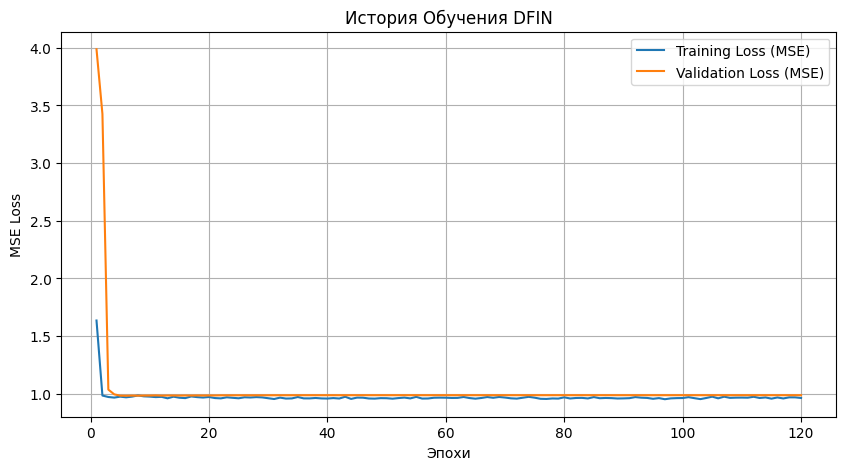

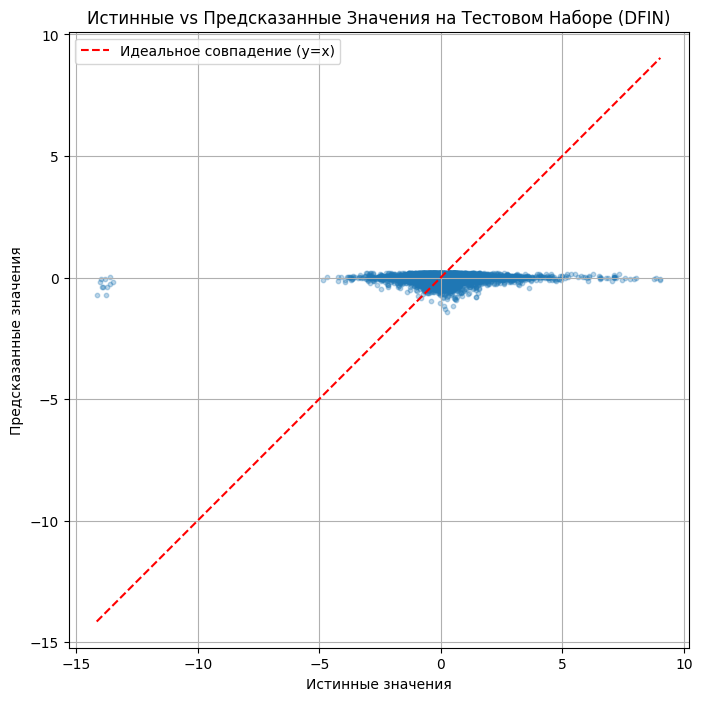


Скрипт завершен.


In [1]:
# --- Основные импорты ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn # Теперь используем nn для кастомной модели
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau # Возвращаем планировщик
from torch.utils.data import DataLoader, TensorDataset
# Используем RobustScaler, т.к. он менее чувствителен к выбросам
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# --- Configuration ---
# Try to mount Google Drive


# Указываем путь к вашему файлу
DATA_FILE_PATH = '0moex_qcml_final_dataset_with_embeddings.parquet'
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# --- Model Hyperparameters ---
INPUT_DIM = -1 # Будет определено после загрузки данных
# Глубокая и широкая модель с остаточными блоками
INITIAL_WIDTH = 512 # Ширина первого слоя
BLOCK_WIDTHS = [512, 256, 256, 128, 64] # Ширина слоев внутри остаточных блоков
OUTPUT_DIM = 1
DROPOUT_RATE = 0.0 # Умеренный Dropout
LEARNING_RATE = 0.1 # Можно начать чуть выше для AdamW
WEIGHT_DECAY = 0.01 # L2 регуляризация для AdamW
BATCH_SIZE = 1024*16   # Уменьшим немного для кастомной модели
EPOCHS = 120      # Количество эпох (может потребоваться больше)

# --- Phase 1: Setup & Data Loading ---
# (Без изменений от предыдущего варианта TabNet)
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
if not os.path.exists(DATA_FILE_PATH):
    print(f"ОШИБКА: Файл данных не найден по пути {DATA_FILE_PATH}")
    print("Создание dummy-данных для демонстрации...")
    num_samples = 10000; num_features = 18; num_days = 100; stocks_per_day = num_samples // num_days
    dummy_data = { DATE_COLUMN: np.repeat(pd.date_range('2010-01-01', periods=num_days, freq='B').astype(np.int64) // 10**9, stocks_per_day) * 1_000_000_000, TARGET_COLUMN: np.random.randn(num_samples),}
    for i in range(num_features): dummy_data[f'feature_{i+1}'] = np.random.randn(num_samples)
    df = pd.DataFrame(dummy_data)
    print("Dummy-данные созданы.")
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet файл: {e}"); raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]
missing_req = [col for col in required_cols if col not in df.columns]
if missing_req: raise ValueError(f"Отсутствуют обязательные столбцы: {missing_req}")
print(f"Обязательные столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns: raise ValueError("Нет признаков для обучения")
INPUT_DIM = len(feature_columns)
print(f"Найдено {INPUT_DIM} столбцов-признаков.")

# --- Phase 2: Initial Time Sort & Data Splitting ---
# (Без изменений)
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: raise ValueError(f"Не удалось конвертировать '{DATE_COLUMN}': {e}")
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
print(f"Данные отсортированы по '{DATE_COLUMN}'.")
split_idx = int(len(df) * 0.9); train_df = df.iloc[:split_idx].copy(); test_df = df.iloc[split_idx:].copy()
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные данные: {len(train_df)} семплов, с {train_start} по {train_end}")
print(f"Тестовые данные     : {len(test_df)} семплов, с {test_start} по {test_end}")
if train_end >= test_start: print(f"ВНИМАНИЕ: Возможно перекрытие дат между train и test!")

# --- Phase 3: Preprocessing (Scaling) ---
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns].values
y_train = train_df[[TARGET_COLUMN]].values # Оставляем 2D для scaler
X_test = test_df[feature_columns].values
y_test = test_df[[TARGET_COLUMN]].values # Оставляем 2D для scaler

# Используем RobustScaler
scaler = RobustScaler()
target_scaler = None # Оставляем цель не масштабированной

print("Обучение масштабировщика признаков..."); X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = y_train # Используем оригинал
print("Применение масштабировщика признаков..."); X_test_scaled = scaler.transform(X_test)
y_test_scaled = y_test # Используем оригинал
print("Признаки масштабированы (цель - нет).")


# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели (DFIN) ---")

# --- Вспомогательный блок ResBlock ---
class ResBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.relu = nn.LeakyReLU(negative_slope=0.01) # Используем LeakyReLU
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)

        # Shortcut connection: если размеры не совпадают, используем линейный слой
        if input_dim != output_dim:
            self.shortcut = nn.Sequential(
                nn.Linear(input_dim, output_dim),
                nn.BatchNorm1d(output_dim)
            )
        else:
            self.shortcut = nn.Identity() # Если размеры совпадают, просто пропускаем

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.fc1(x)
        if out.shape[0] > 1: out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        if out.shape[0] > 1: out = self.bn2(out)

        out += identity # Добавляем shortcut connection
        out = self.relu(out) # Финальная активация блока
        return out

# --- Основная модель DFIN ---
class DFIN(nn.Module):
    def __init__(self, input_dim, initial_width, block_widths, output_dim, dropout_rate):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Linear(input_dim, initial_width),
            nn.BatchNorm1d(initial_width),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_rate)
        )

        self.res_blocks = nn.ModuleList()
        current_dim = initial_width
        for width in block_widths:
            self.res_blocks.append(ResBlock(current_dim, width, dropout_rate))
            current_dim = width # Обновляем размерность для следующего блока

        self.final_layer = nn.Linear(current_dim, output_dim)

    def forward(self, x):
        x = self.initial_layer(x)
        for block in self.res_blocks:
            x = block(x)
        x = self.final_layer(x)
        return x


# --- Подготовка к обучению ---
# Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32) # Target shape (N, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32) # Target shape (N, 1)

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=min(4, os.cpu_count())) # Увеличим num_workers, если возможно
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, pin_memory=True, num_workers=min(4, os.cpu_count())) # Можно увеличить batch_size для валидации

# Instantiate model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

model = DFIN(INPUT_DIM, INITIAL_WIDTH, BLOCK_WIDTHS, OUTPUT_DIM, DROPOUT_RATE).to(device)
criterion = nn.MSELoss() # Используем MSE для регрессии
# Используем AdamW с weight decay
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Планировщик learning rate (с увеличенным терпением)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=1.0)

# --- Training Loop ---
train_losses = []
val_losses = []
best_val_loss = float('inf') # Для сохранения лучшей модели
best_model_state = None
start_time = time.time()

print("Начало обучения DFIN...")
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    batch_count = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # clip_grad_norm_(model.parameters(), max_norm=1.0) # Опционально: обрезка градиентов
        optimizer.step()
        epoch_train_loss += loss.item()
        batch_count += 1

    avg_train_loss = epoch_train_loss / batch_count
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    batch_count = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()
            batch_count += 1

    avg_val_loss = epoch_val_loss / batch_count
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Сохранение лучшей модели по val_loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        print(f"   *** Новая лучшая модель сохранена (Val Loss: {best_val_loss:.6f}) ***")

    # Шаг планировщика
    scheduler.step(avg_val_loss)

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# Загрузка лучшей модели для предсказания
if best_model_state:
    print("Загрузка лучшей модели для финальной оценки...")
    model.load_state_dict(best_model_state)
else:
    print("Предупреждение: Лучшая модель не была сохранена, используется модель из последней эпохи.")


# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (DFIN) ---")

model.eval()
predictions_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions_list.append(outputs.cpu().numpy())

predictions_original_scale = np.concatenate(predictions_list, axis=0)
# Приводим к 1D, если нужно
if predictions_original_scale.ndim > 1:
    predictions_original_scale = predictions_original_scale.flatten()

# Цель уже в оригинальном масштабе (y_test_scaled это y_test)
y_test_original_scale = y_test_scaled.flatten()

# Оценка модели
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)

print("\n--- Финальные Метрики ---")
print(f"Тестовый набор MSE: {final_mse:.6f}")
print(f"Тестовый набор MAE: {final_mae:.6f}")
print(f"Тестовый набор R^2: {final_r2:.4f}")


# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")

# 1. Кривая обучения (Потери)
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss (MSE)')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss (MSE)')
plt.xlabel('Эпохи')
plt.ylabel('MSE Loss')
plt.title('История Обучения DFIN')
plt.legend()
plt.grid(True)
plt.show()

# 2. График "Истинные vs Предсказанные значения"
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Истинные vs Предсказанные Значения на Тестовом Наборе (DFIN)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min())
max_val = max(y_test_original_scale.max(), predictions_original_scale.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное совпадение (y=x)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

print("\nСкрипт завершен.")

Попытка загрузить данные из: 0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Обязательные столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков.

--- Сортировка и разбиение данных ---
Данные отсортированы по 'TRADEDATE'.
Тренировочные данные: 150827 семплов, с 2021-04-20 00:00:00 по 2024-11-18 00:00:00
Тестовые данные     : 16759 семплов, с 2024-11-18 00:00:00 по 2025-03-27 00:00:00
ВНИМАНИЕ: Возможно перекрытие дат между train и test!

--- Предобработка (Масштабирование) ---
Обучение масштабировщика признаков...
Применение масштабировщика признаков...
Признаки масштабированы (цель - нет).

--- Определение и Обучение Модели (DFIN v3 с GLU и ResBlocks) ---
Используемое устройство: cuda
Начало обучения DFIN v3...
Эпоха [1/230], Train Loss: 1.043133, Val Loss: 0.967309, LR: 0.0000500
Эпоха [2/230], Train Loss: 0.992381, Val Loss: 0.971143, LR: 0.0001000
Эпоха [3/230], Train Loss: 0.986559, Val Loss: 0.973410, LR: 0.0

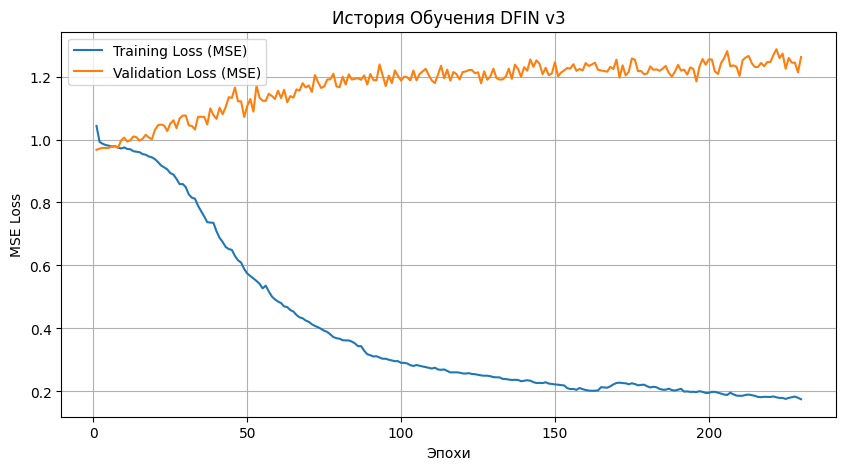

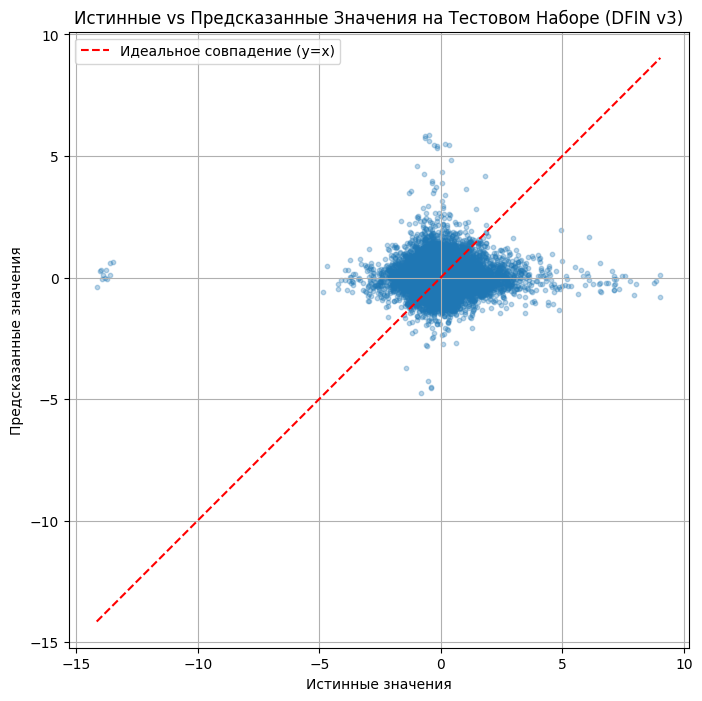


Скрипт завершен.


In [8]:
# --- Основные импорты ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR # Добавляем LambdaLR для warmup
# Импорт SWA
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os
import math # Для warmup

# --- Configuration ---
# Try to mount Google Drive

DATA_FILE_PATH = '0moex_qcml_final_dataset_with_embeddings.parquet'
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# --- Model Hyperparameters ---
INPUT_DIM = -1
# Параметры для DFIN v3
EMBEDDING_DIM = 256     # Размерность после начального преобразования
NUM_BLOCKS = 5         # Количество ResGLU блоков
BLOCK_HIDDEN_FACTOR = 3 # Множитель для скрытого слоя внутри ResGLU
OUTPUT_DIM = 1
DROPOUT_RATE = 0.15    # Немного уменьшим dropout, т.к. GLU уже имеют некий гейтинг
# Параметры обучения
LEARNING_RATE = 1e-3    # Начальный LR (может быть выше из-за warmup)
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 1024*4
EPOCHS = 230           # Больше эпох для сложной модели и SWA
# Параметры Warmup
WARMUP_EPOCHS = 20
# Параметры SWA
SWA_START_EPOCH = 160  # Эпоха, с которой начинаем SWA
SWA_LR = 1e-3         # LR для SWA фазы

# --- Phase 1: Setup & Data Loading ---
# (Без изменений)
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
if not os.path.exists(DATA_FILE_PATH):
    print(f"ОШИБКА: Файл данных не найден по пути {DATA_FILE_PATH}")
    print("Создание dummy-данных для демонстрации...")
    num_samples = 10000; num_features = 18; num_days = 100; stocks_per_day = num_samples // num_days
    dummy_data = { DATE_COLUMN: np.repeat(pd.date_range('2010-01-01', periods=num_days, freq='B').astype(np.int64) // 10**9, stocks_per_day) * 1_000_000_000, TARGET_COLUMN: np.random.randn(num_samples),}
    for i in range(num_features): dummy_data[f'feature_{i+1}'] = np.random.randn(num_samples)
    df = pd.DataFrame(dummy_data); print("Dummy-данные созданы.")
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet файл: {e}"); raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]; missing_req = [col for col in required_cols if col not in df.columns]
if missing_req: raise ValueError(f"Отсутствуют обязательные столбцы: {missing_req}")
print(f"Обязательные столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns: raise ValueError("Нет признаков для обучения")
INPUT_DIM = len(feature_columns); print(f"Найдено {INPUT_DIM} столбцов-признаков.")

# --- Phase 2: Initial Time Sort & Data Splitting ---
# (Без изменений)
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: raise ValueError(f"Не удалось конвертировать '{DATE_COLUMN}': {e}")
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True); print(f"Данные отсортированы по '{DATE_COLUMN}'.")
split_idx = int(len(df) * 0.9); train_df = df.iloc[:split_idx].copy(); test_df = df.iloc[split_idx:].copy()
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные данные: {len(train_df)} семплов, с {train_start} по {train_end}"); print(f"Тестовые данные     : {len(test_df)} семплов, с {test_start} по {test_end}")
if train_end >= test_start: print(f"ВНИМАНИЕ: Возможно перекрытие дат между train и test!")

# --- Phase 3: Preprocessing (Scaling) ---
# (Без изменений - RobustScaler для признаков, цель не масштабируем)
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns].values; y_train = train_df[[TARGET_COLUMN]].values
X_test = test_df[feature_columns].values; y_test = test_df[[TARGET_COLUMN]].values
scaler = RobustScaler(); target_scaler = None
print("Обучение масштабировщика признаков..."); X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = y_train
print("Применение масштабировщика признаков..."); X_test_scaled = scaler.transform(X_test)
y_test_scaled = y_test
print("Признаки масштабированы (цель - нет).")

# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели (DFIN v3 с GLU и ResBlocks) ---")

# --- Вспомогательный блок GLU ---
class GLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = nn.Linear(dim_in, dim_out * 2) # Выход в 2 раза больше для гейта

    def forward(self, x):
        out = self.linear(x)
        # Разделяем выход на две части: основную и гейт
        # Используем сигмоиду для гейта
        return out[:, :out.shape[1]//2] * torch.sigmoid(out[:, out.shape[1]//2:])

# --- Улучшенный ResBlock с GLU ---
class ResGLUBlock(nn.Module):
    def __init__(self, dim, hidden_factor, dropout_rate):
        super().__init__()
        hidden_dim = int(dim * hidden_factor)
        self.norm1 = nn.BatchNorm1d(dim) # Нормализация перед GLU
        self.glu = GLU(dim, hidden_dim)
        self.norm2 = nn.BatchNorm1d(hidden_dim) # Нормализация перед вторым Linear
        self.fc = nn.Linear(hidden_dim, dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        identity = x
        out = self.norm1(x)
        out = self.glu(out)
        out = self.norm2(out)
        out = self.dropout(out)
        out = self.fc(out)
        out = out + identity # Residual connection
        return out

# --- Основная модель DFIN v3 ---
class DFIN_v3(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_blocks, block_hidden_factor, output_dim, dropout_rate):
        super().__init__()
        # Начальное преобразование/вложение
        self.initial_layer = nn.Sequential(
            nn.Linear(input_dim, embedding_dim * 2), # Увеличиваем для GLU
             # Убрали BatchNorm здесь, т.к. он будет в ResGLUBlock
        )
        self.initial_glu = GLU(embedding_dim * 2, embedding_dim)
        self.initial_norm = nn.BatchNorm1d(embedding_dim)
        self.initial_dropout = nn.Dropout(dropout_rate)

        # Последовательность ResGLU блоков
        self.res_blocks = nn.Sequential(
            *[ResGLUBlock(embedding_dim, block_hidden_factor, dropout_rate) for _ in range(num_blocks)]
        )

        # Финальный слой
        self.final_norm = nn.BatchNorm1d(embedding_dim) # Нормализация перед последним слоем
        self.final_layer = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.initial_glu(x)
        if x.shape[0] > 1: x = self.initial_norm(x)
        x = self.initial_dropout(x)
        x = self.res_blocks(x)
        if x.shape[0] > 1: x = self.final_norm(x)
        x = self.final_layer(x)
        return x


# --- Подготовка к обучению ---
# Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=min(4, os.cpu_count()))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, pin_memory=True, num_workers=min(4, os.cpu_count()))

# Instantiate model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

model = DFIN_v3(INPUT_DIM, EMBEDDING_DIM, NUM_BLOCKS, BLOCK_HIDDEN_FACTOR, OUTPUT_DIM, DROPOUT_RATE).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# --- Планировщики LR: Warmup + ReduceLROnPlateau ---
# Warmup scheduler
def warmup_lambda(current_epoch):
    if current_epoch < WARMUP_EPOCHS:
        # Линейное увеличение от 0 до 1 за WARMUP_EPOCHS
        return float(current_epoch + 1) / float(max(1, WARMUP_EPOCHS))
    return 1.0 # После warmup LR не меняется этим планировщиком

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
# Основной планировщик после warmup
main_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=65, verbose=True, threshold=0.1)

# SWA Модель (инициализируем, но пока не используем)
swa_model = AveragedModel(model)
swa_scheduler = SWALR(optimizer, swa_lr=SWA_LR) # Планировщик для SWA фазы


# --- Training Loop ---
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
start_time = time.time()
print("Начало обучения DFIN v3...")

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0; batch_count = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item(); batch_count += 1
    avg_train_loss = epoch_train_loss / batch_count
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0; batch_count = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item(); batch_count += 1
    avg_val_loss = epoch_val_loss / batch_count
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # --- Обновление планировщиков ---
    if epoch < WARMUP_EPOCHS:
        warmup_scheduler.step() # Шаг warmup планировщика
    else:
        # --- Фаза SWA ---
        if epoch >= SWA_START_EPOCH:
            swa_model.update_parameters(model) # Обновляем средние веса SWA
            swa_scheduler.step() # Шаг SWA планировщика (с низким LR)
            if epoch == EPOCHS - 1: # В конце последней эпохи SWA
                 # Обновляем статистики BatchNorm для SWA модели
                 print("Обновление BatchNorm для SWA модели...")
                 # Прогоняем весь трейнлоадер через SWA модель в режиме train
                 # чтобы обновить running_mean и running_var в BatchNorm слоях
                 torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
                 print("BatchNorm для SWA обновлен.")
        else:
             # --- Обычная фаза после warmup ---
             main_scheduler.step(avg_val_loss) # Шаг основного планировщика ReduceLROnPlateau
             # Сохранение лучшей модели (только до начала SWA)
             if avg_val_loss < best_val_loss:
                 best_val_loss = avg_val_loss
                 best_model_state = model.state_dict()
                 print(f"   *** Новая лучшая модель сохранена (Val Loss: {best_val_loss:.6f}) ***")


training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# --- Выбор модели для оценки ---
# Если SWA использовался, оцениваем SWA модель
if EPOCHS > SWA_START_EPOCH:
    print("Использование SWA модели для финальной оценки.")
    final_model = swa_model.module.to(device) # .module для доступа к оригинальной архитектуре внутри AveragedModel
else:
    # Иначе используем лучшую модель, сохраненную до SWA
    if best_model_state:
        print("Загрузка лучшей модели (до SWA) для финальной оценки...")
        # Нужно создать новый экземпляр модели и загрузить состояние
        model.load_state_dict(best_model_state)
        final_model = model
    else:
        print("Предупреждение: Лучшая модель не найдена, используется модель из последней эпохи.")
        final_model = model

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (DFIN v3) ---")

final_model.eval() # Убедимся, что выбранная модель в режиме eval
predictions_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = final_model(inputs)
        predictions_list.append(outputs.cpu().numpy())

predictions_original_scale = np.concatenate(predictions_list, axis=0)
if predictions_original_scale.ndim > 1: predictions_original_scale = predictions_original_scale.flatten()
y_test_original_scale = y_test_scaled.flatten()

# Оценка модели
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)

print("\n--- Финальные Метрики ---")
print(f"Тестовый набор MSE: {final_mse:.6f}")
print(f"Тестовый набор MAE: {final_mae:.6f}")
print(f"Тестовый набор R^2: {final_r2:.4f}")


# --- Phase 6: Visualization ---
# (Без изменений, использует train_losses и val_losses из основного цикла)
print("\n--- Построение Графиков ---")
# 1. Кривая обучения (Потери)
plt.figure(figsize=(10, 5)); plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss (MSE)'); plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss (MSE)'); plt.xlabel('Эпохи'); plt.ylabel('MSE Loss'); plt.title('История Обучения DFIN v3'); plt.legend(); plt.grid(True); plt.show()
# 2. График "Истинные vs Предсказанные значения"
plt.figure(figsize=(8, 8)); plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10); plt.xlabel('Истинные значения'); plt.ylabel('Предсказанные значения'); plt.title('Истинные vs Предсказанные Значения на Тестовом Наборе (DFIN v3)'); min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max()); plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное совпадение (y=x)'); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()

print("\nСкрипт завершен.")